# CIV+LIT(w/ MBHs) compared to new simulation data

## Ben: May 12-14 ish; Nicole: June 5th 

## COS-Holes DATA & Literature DATA

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
#cosholes_df

In [4]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
#up_ch

#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
#sum_ch

#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
#com_ch

In [108]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

amiga_2_det_sum

,index,QSO,z,RAdeg,Decdeg,Rad,ion,b_Vel,B_Vel,Vel,e_V,logN,sumlogN,E_logN,e_logN,sum_elogN,f_logN,MS
3,49,HS0033+4300,0.120,9.096,43.278,30.5,C IV,-300,-150,-215.8,3.0,14.10,14.100000,0.04,0.05,0.050000,0,0
4,61,HS0058+4213,0.190,15.380,42.493,48.6,C IV,-275,-215,-232.7,6.3,13.33,13.904521,0.12,0.17,0.183848,0,0
6,97,RX_J0043.6+3725,0.080,10.927,37.422,50.5,C IV,-250,-120,-188.5,2.5,13.85,13.850000,0.03,0.03,0.030000,0,0
7,121,Zw535.012,0.048,9.087,45.665,59.7,C IV,-250,-200,-215.3,7.2,12.99,13.414814,0.16,0.26,0.300167,0,0
9,145,RX_J0050.8+3536,0.058,12.711,35.612,77.1,C IV,-300,-190,-237.1,4.7,13.45,13.450000,0.06,0.07,0.070000,0,0
10,183,IRAS_F00040+4325,0.163,1.652,43.708,93.0,C IV,-281,-195,-238.0,3.8,13.23,13.475162,0.06,0.07,0.106301,0,0
12,230,MRK352,0.015,14.972,31.827,131.7,C IV,-350,-267,-282.2,4.1,13.50,14.156552,0.06,0.07,0.152971,0,0
15,296,KAZ238,0.043,0.242,33.344,150.2,C IV,-370,-305,-333.7,4.2,13.45,13.862443,0.09,0.11,0.136015,0,0
17,362,PG0052+251,0.155,13.717,25.427,209.8,C IV,-347,-230,-285.6,3.8,13.41,13.742065,0.05,0.05,0.064031,0,0
19,386,RXS_J0155.6+3115,0.135,28.900,31.255,231.6,C IV,-270,-140,-210.0,3.5,13.92,13.920000,0.05,0.05,0.050000,0,0


In [89]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [7]:
#EAGLE

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.5.0_7.375.dat",sep=" ")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.7.375_9.75.dat",sep=" ")

########################################################

# TNG 

df_r_new_lowtng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.6.05_8.225.dat",sep=" ")
df_r_new_hightng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.8.225_10.4.dat",sep=" ")

########################################################

# R25: New Data from Nicole (June 5th 2023)

r25_rr = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_RoverRvir_new.txt', 
                       sep=" ", header=None, names =['Rproj/Rvir'])
r25_r = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['Rproj'])

#High MBH Things 
hmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
hmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_16percentile_new.txt.txt', 
                       sep=" ", header=None, names =['16per'])
hmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_84percentile_new.txt.txt', 
                       sep=" ", header=None, names =['84per'])

#Low MBH Things 
lmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
lmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])
lmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

#Galaxy Histogram info 
r25_mhalo = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mhalo.txt', 
                       sep=" ", header=None, names =['Mhalo'])

r25_mbh = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Msmbh.txt', 
                       sep=" ", header=None, names =['Mbh'])

r25_mstar = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mstar.txt', 
                       sep=" ", header=None, names =['Mhalo'])

#All the MBH together
all_r25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])

all_r25_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])


all_r25_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

In [82]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

#arrays for plotting  
civ_B13 = np.array(borthakur_no_zero['logNCIV[i]'])
civ_err_B13 = np.array(borthakur_no_zero['err'])
det_B13 = np.array(borthakur_no_zero['det'])
RpRv_B13 = np.array(borthakur_no_zero['rhokpc[i]/rvir[i]']) #Rproj/Rvir 
Rp_B13 = np.array(borthakur_no_zero['rhokpc[i]'])

########################################################

#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

#arrays for plotting 
civ_B14 = np.array(bordoloi['logNCIV'])
civ_err_B14 = np.array(bordoloi['err'])
det_B14 = np.array(bordoloi['det'])
RpRv_B14 = np.array(bordoloi['R/Rvir']) #Rproj/Rvir 
Rp_B14 = np.array(bordoloi['R[kpc]'])

########################################################

#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
               'Rproj/Rvir': [0.34, 0.39],
               'Rproj': [112, 97],
               'NCIV': [14.10, 13.90],
               'sigNCIV': [0.09, 0.03], 
           'v': [257.89, 302.01], 
           'v_err': [37, 45]}
COSHALOS = pd.DataFrame(data=coshalos)

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [38]:
burchett_virsel = pd.read_table("/Users/samgarza/Downloads/Burchett2016_CIV_HI_virselect.dat",sep="|")
#burchett_virsel 

In [39]:
burchett_virsel = burchett_virsel.loc[[32,48,52]] #These are all below the threshold we want anyway which is annoying 

,Unnamed: 0,field,ra_gal,dec_gal,zgal,NSAidx,mstars,rrvir,rhokpc,col_c4,colsig_c4,EW_c4,EWsig_c4,flag_c4,flag_h1,EW_h1,EWsig_h1,col_h1,colsig_h1,ra_qso,dec_qso,SFR,SFR_err,mhalo,mhalosingle,Unnamed: 25
32,NaN,J0928+6025,142.537672,60.468268,0.013547,11322,8.456981,1.594651,193.806595,13.766487,0.030637,0.159751,0.017804,1,3,0.840978,-99.0,14.188721,-99.0,142.158260,60.422500,0.173052,0.0,10.768004,10.776802,NaN
48,NaN,J1445+3428,221.334147,34.330111,0.005558,60956,8.689807,0.463063,61.203327,14.147408,0.128350,0.190992,0.050720,1,0,0.000000,0.0,0.000000,0.0,221.297010,34.473740,0.072467,0.0,10.864423,10.875788,NaN
52,NaN,pg1148,177.662239,55.353965,0.003165,37673,9.526175,0.979877,174.897491,13.664607,0.027767,0.089840,0.007000,1,2,0.358889,-99.0,14.167052,99.0,177.835255,54.625855,0.056915,99.0,11.242672,11.264115,NaN


In [47]:
#These are all below the threshold we want anyway which is annoying 

burchett_kpcsel= pd.read_table("/Users/samgarza/Downloads/Burchett2016_CIV_HI_kpcselect.dat",sep="|")
burchett_kpcsel = burchett_kpcsel.loc[[38,39,60,65]]
burchett_kpcsel

,Unnamed: 0,field,ra_gal,dec_gal,zgal,NSAidx,mstars,rrvir,rhokpc,col_c4,colsig_c4,EW_c4,EWsig_c4,flag_c4,flag_h1,EW_h1,EWsig_h1,col_h1,colsig_h1,ra_qso,dec_qso,SFR,SFR_err,mhalo,mhalosingle,Unnamed: 25
38,NaN,J0928+6025,142.528260,60.447809,0.013659,11323,8.112260,1.734269,186.904449,13.766487,0.030637,0.159751,0.017804,1,3,0.840978,-99.000000,14.188721,-99.0,142.158260,60.422500,0.333166,0.0,10.620346,10.626371,NaN
39,NaN,J0928+6025,142.530206,60.139051,0.010711,121731,8.658054,2.087719,269.857086,13.101096,-99.000000,0.051879,-99.000000,3,2,0.339839,0.059575,14.000000,99.0,142.158260,60.422500,0.040707,0.0,10.853427,10.864320,NaN
60,NaN,J1445+3428,221.334147,34.330111,0.005558,60956,8.689807,0.467120,61.203327,14.147408,0.128350,0.190992,0.050720,1,0,0.000000,0.000000,0.000000,0.0,221.297010,34.473740,0.072467,0.0,10.864423,10.875788,NaN
65,NaN,pg1148,178.847982,54.657281,0.002839,139944,8.330253,1.075626,125.349594,13.664607,0.027767,0.089840,0.007000,1,2,0.358889,-99.000000,14.167052,99.0,177.835255,54.625855,0.016128,99.0,10.708240,10.716067,NaN


## Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [12]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [13]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10.0) & (bordoloi_less150['logM*'] <= 11.0)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680


In [14]:
####### BURCHETT VIR SELECTED ######### 

burchett_vir_less150 = burchett_virsel.loc[burchett_virsel['        rhokpc '] <= 150]
#burchett_vir_less150
burchett_vir_sms = burchett_vir_less150.loc[(burchett_vir_less150['        mstars '] >= 10.0) & (burchett_vir_less150['        mstars '] <= 11.0)]
burchett_vir_sms

,Unnamed: 0,field,ra_gal,dec_gal,zgal,NSAidx,mstars,rrvir,rhokpc,col_c4,colsig_c4,EW_c4,EWsig_c4,flag_c4,flag_h1,EW_h1,EWsig_h1,col_h1,colsig_h1,ra_qso,dec_qso,SFR,SFR_err,mhalo,mhalosingle,Unnamed: 25
4,NaN,J1059+1441,165.07691,13.901067,0.002302,139317,10.461143,0.518805,139.543182,14.059528,0.039051,0.271609,0.022238,1,2,0.541917,0.031224,14.148576,99.0,164.9385,14.6953,0.315433,0.0,11.897495,11.79727,NaN


In [15]:
####### BURCHETT KPC SELECTED ######### 

burchett_kpc_less150 = burchett_kpcsel.loc[burchett_kpcsel['        rhokpc '] <= 150]
#burchett_kpc_less150
burchett_kpc_sms = burchett_kpc_less150.loc[(burchett_kpc_less150['        mstars '] >= 10.0) & (burchett_kpc_less150['        mstars '] <= 11.0)]
burchett_kpc_sms

,Unnamed: 0,field,ra_gal,dec_gal,zgal,NSAidx,mstars,rrvir,rhokpc,col_c4,colsig_c4,EW_c4,EWsig_c4,flag_c4,flag_h1,EW_h1,EWsig_h1,col_h1,colsig_h1,ra_qso,dec_qso,SFR,SFR_err,mhalo,mhalosingle,Unnamed: 25
9,NaN,J1059+1441,165.07691,13.901067,0.002302,139317,10.461143,0.480392,139.543182,14.059528,0.039051,0.271609,0.022238,1,2,0.541917,0.031224,14.148576,99.0,164.9385,14.6953,0.315433,0.0,11.897495,11.79727,NaN


## Using the Velocity Dispersions of the Galaxy to calculate the MBH for each of our literature values

In [16]:
gals = fits.open('/Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit')
gals.info()

Filename: /Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     67   927552R x 25C   [I, J, I, 5I, E, E, 5E, I, I, 19A, 6A, 21A, E, E, I, E, E, E, E, E, E, 3E, 3E, 5E, 12A]   


In [152]:
gal_data = gals[1].data

In [18]:
#Values that I need to search for the vdisps for the specific galaxy/qso using from literature 

#BORDOLOI VALUES 
pids = np.array([2105, 511, 833, 2227, 995])
mjds = np.array([53472, 52636, 52314, 53820, 52731])
fids = np.array([407, 449, 104, 491, 208])

#BORTHAKUR VALUES 

pids_borth = np.array([1167, 526, 1430, 1285])
mjds_borth = np.array([52738, 52312, 53002, 52723])
fids_borth = np.array([638, 529, 237, 37])

In [19]:
#For Bordoloi
vdisps = []
vdisps_err = []

for i in range(len(pids)): 
    #Plate ID
    mask = gal_data.PLATEID == pids[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps.append(test.V_DISP)
    vdisps_err.append(test.V_DISP_ERR)
    
vdisps = np.array(vdisps)
vdisps = vdisps.reshape(5,)
#vdisps

vdisps_err = np.array(vdisps_err)
vdisps_err = vdisps_err.reshape(5,)
#vdisps_err

(1,)
V_DISP: [57.136898], V_DISP_ERR:[13.070264]
(1,)
V_DISP: [41.15367], V_DISP_ERR:[9.7062435]
(1,)
V_DISP: [43.57293], V_DISP_ERR:[7.5054946]
(1,)
V_DISP: [33.40527], V_DISP_ERR:[16.83185]
(1,)
V_DISP: [77.021416], V_DISP_ERR:[17.392845]


In [20]:
#For Borthakur
vdisps_borth = []
vdisps_err_borth = []

for i in range(len(pids_borth)): 
    #Plate ID
    mask = gal_data.PLATEID == pids_borth[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds_borth[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids_borth[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps_borth.append(test.V_DISP)
    vdisps_err_borth.append(test.V_DISP_ERR)
    
vdisps_borth = np.array(vdisps_borth)
vdisps_borth = vdisps_borth.reshape(4,)
#vdisps

vdisps_err_borth = np.array(vdisps_err_borth)
vdisps_err_borth = vdisps_err_borth.reshape(4,)
#vdisps_err

(1,)
V_DISP: [76.28716], V_DISP_ERR:[17.076445]
(1,)
V_DISP: [148.91199], V_DISP_ERR:[7.8888116]
(1,)
V_DISP: [121.198685], V_DISP_ERR:[18.669765]
(1,)
V_DISP: [134.5503], V_DISP_ERR:[24.878817]


### Using Equation (7) from Piotrowska et al 2022 to take the velocity dispersions that we just found and get the MBH 
(https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1052P/abstract)

In [21]:
#BORDOLOI MBH AND ERROR
logMBH_bord = (5.246 * np.log10(vdisps)) - 3.77 #epsilon = 0.417
    #logMBH_bord = np.round(logMBH_bord.astype(np.int64), 3)
logMBH_bord

array([5.4467845, 4.6991878, 4.829331 , 4.223933 , 6.1271634],
      dtype=float32)

In [144]:
logMBH_bord_err_down = (5.246 * np.log10(vdisps - vdisps_err)) - 3.77 #epsilon = 0.417
    #logMBH_bord_err = logMBH_bord_err.astype(np.int64)
logMBH_bord_err_down

array([4.855    , 4.0863314, 4.398627 , 2.6270356, 5.5440335],
      dtype=float32)

In [79]:
logMBH_bord_err_up = (5.246 * np.log10(vdisps + vdisps_err)) - 3.77 #epsilon = 0.417
    #logMBH_bord_err = logMBH_bord_err.astype(np.int64)
logMBH_bord_err_up

array([5.916116 , 5.181646 , 5.1914134, 5.1535754, 6.591047 ],
      dtype=float32)

In [149]:
logMBH_bord_err = (logMBH_bord_err_down+logMBH_bord_err_up)/2
logMBH_bord_err

array([5.385558 , 4.6339884, 4.79502  , 3.8903055, 6.06754  ],
      dtype=float32)

In [23]:
#BORDOLOI MBH AND ERROR
logMBH_borth = (5.246 * np.log10(vdisps_borth)) - 3.77 #epsilon = 0.417
logMBH_borth

array([6.1053395, 7.629189 , 7.16003  , 7.398128 ], dtype=float32)

In [146]:
logMBH_borth_err_down = (5.246 * np.log10(vdisps_borth - vdisps_err_borth)) - 3.77 #epsilon = 0.417
logMBH_borth_err_down

array([5.528012 , 7.505178 , 6.7788997, 6.9323306], dtype=float32)

In [147]:
logMBH_borth_err_up = (5.246 * np.log10(vdisps_borth + vdisps_err_borth)) - 3.77 #epsilon = 0.417
logMBH_borth_err_up

array([6.5655513, 7.746796 , 7.486446 , 7.7846694], dtype=float32)

In [150]:
logMBH_borth_err = (logMBH_borth_err_down+logMBH_borth_err_up)/2
logMBH_borth_err

array([6.0467815, 7.625987 , 7.132673 , 7.3585   ], dtype=float32)

In [26]:
#Adding the mbhs to the literature tables (that have been shortened due to stellar mass) 

#For the sum values 
mini_borth= {'MBH': logMBH_borth,
             'MBH_err': logMBH_borth_err}
mini_borth = pd.DataFrame(data=mini_borth)
#mini_borth

In [27]:
#For the sum values 
mini_bord= {'MBH': logMBH_bord,
             'MBH_err': logMBH_bord_err}
mini_bord = pd.DataFrame(data=mini_bord)
#mini_bord

In [68]:
#All the data for Borthakur
borthakur_new = pd.concat([borthakur_high.reset_index(drop=True), mini_borth], axis=1)
borthakur_new

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det,MBH,MBH_err
0,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0,6.105340,2.695157
1,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0,7.629189,0.935723
2,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1,7.160030,2.898395
3,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1,7.398128,3.552522


In [29]:
#Split into det and non det 

borth_det = borthakur_new.loc[(borthakur_new['det'] == 1)]
#borth_det

borth_uplim = borthakur_new.loc[(borthakur_new['det'] == 0)]
#borth_uplim

In [67]:
#All the data for Bordoloi
bordoloi_new = pd.concat([bordoloi_high.reset_index(drop=True), mini_bord], axis=1)
bordoloi_new

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir,MBH,MBH_err
0,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882,5.446784,2.086028
1,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300,4.699188,1.408071
2,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795,4.829331,0.822240
3,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205,4.223933,2.662287
4,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680,6.127163,2.736984


In [31]:
bord_det = bordoloi_new.loc[(bordoloi_new['det'] == 1)]
#bord_det

bord_uplim = bordoloi_new.loc[(bordoloi_new['det'] == 0)]
#bord_uplim

bord_lolim = bordoloi_new.loc[(bordoloi_new['det'] == 2)]
#bord_lolim

## Seeing the spread of MBHs and M*s now with the expanded sample

In [32]:
#creating masks to separate into high and low for COS-Holes
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

#Creating masks for literature 

low_mask_borth, high_mask_borth = (borthakur_new["MBH"] <= 7.6), (borthakur_new["MBH"] > 7.6)
low_mask_bord, high_mask_bord = (bordoloi_new["MBH"] <= 7.6), (bordoloi_new["MBH"] > 7.6)

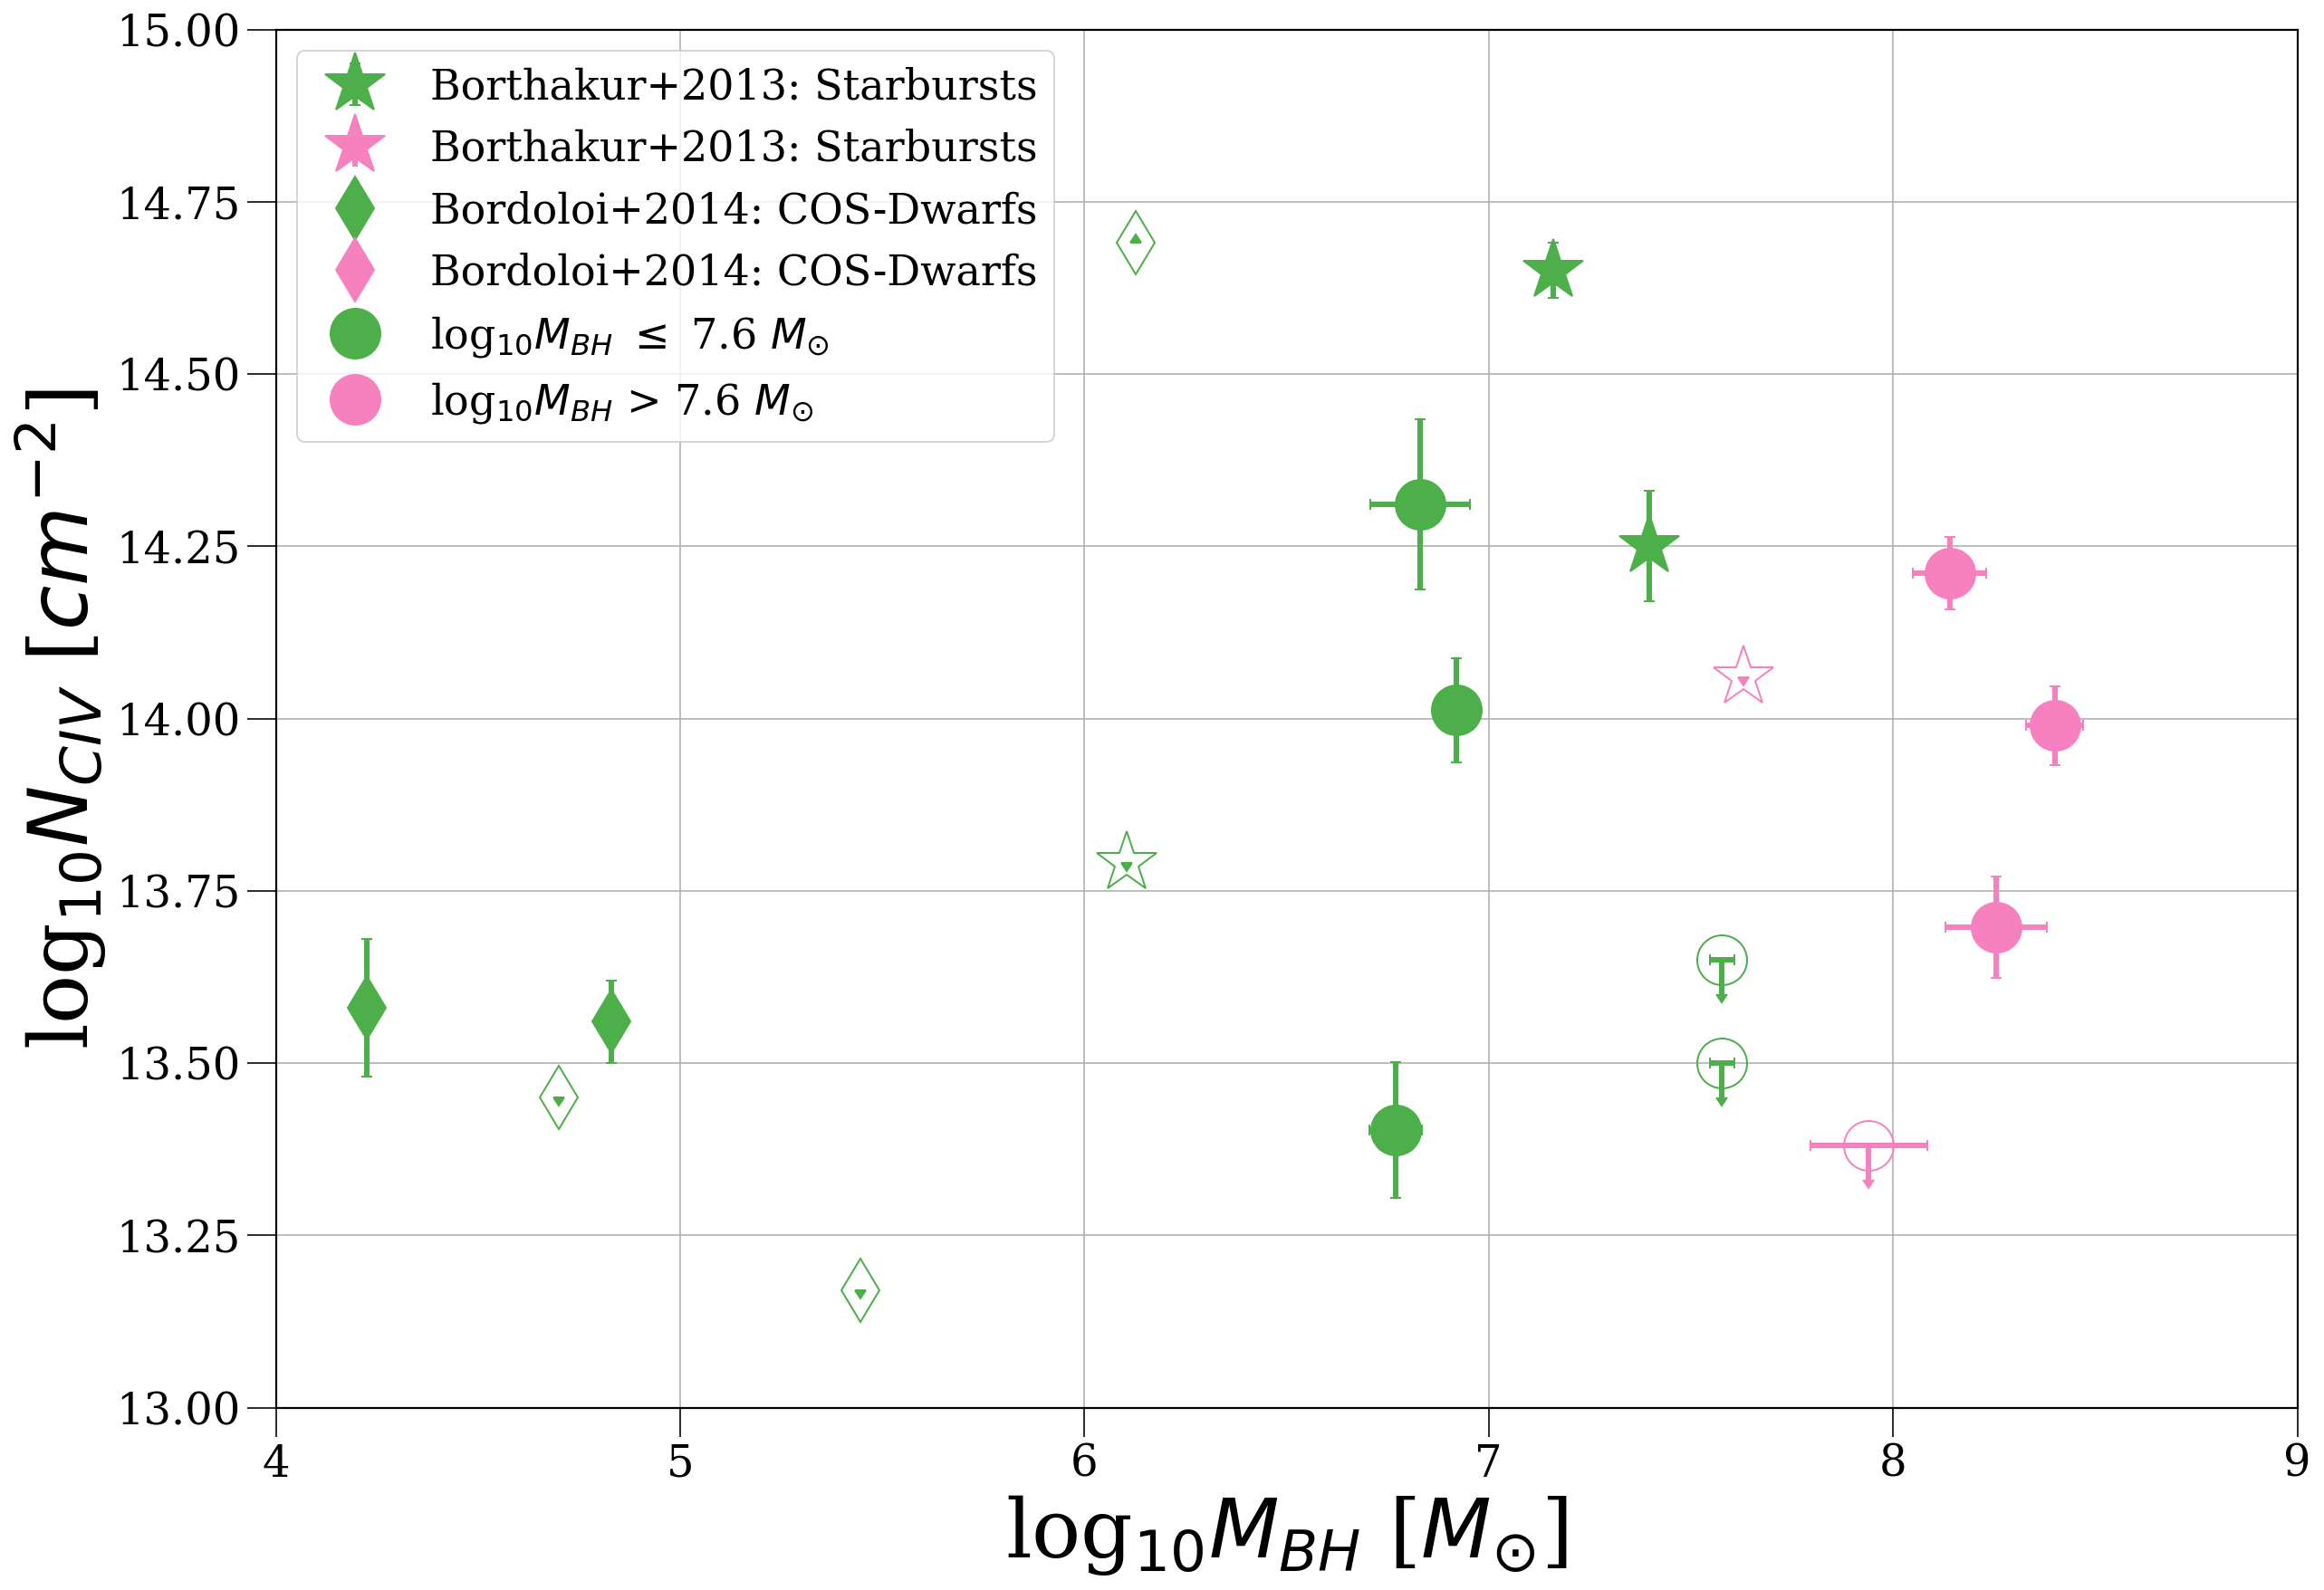

In [33]:
#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['MBH'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['MBH'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['MBH'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['MBH'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['MBH'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["MBH"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["MBH"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=2, fontsize=23)
ax.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
ax.set_xlim(4, 9)
plt.grid(True)
#plt.savefig('Figures/nciv_vs_bh.png')
plt.show()

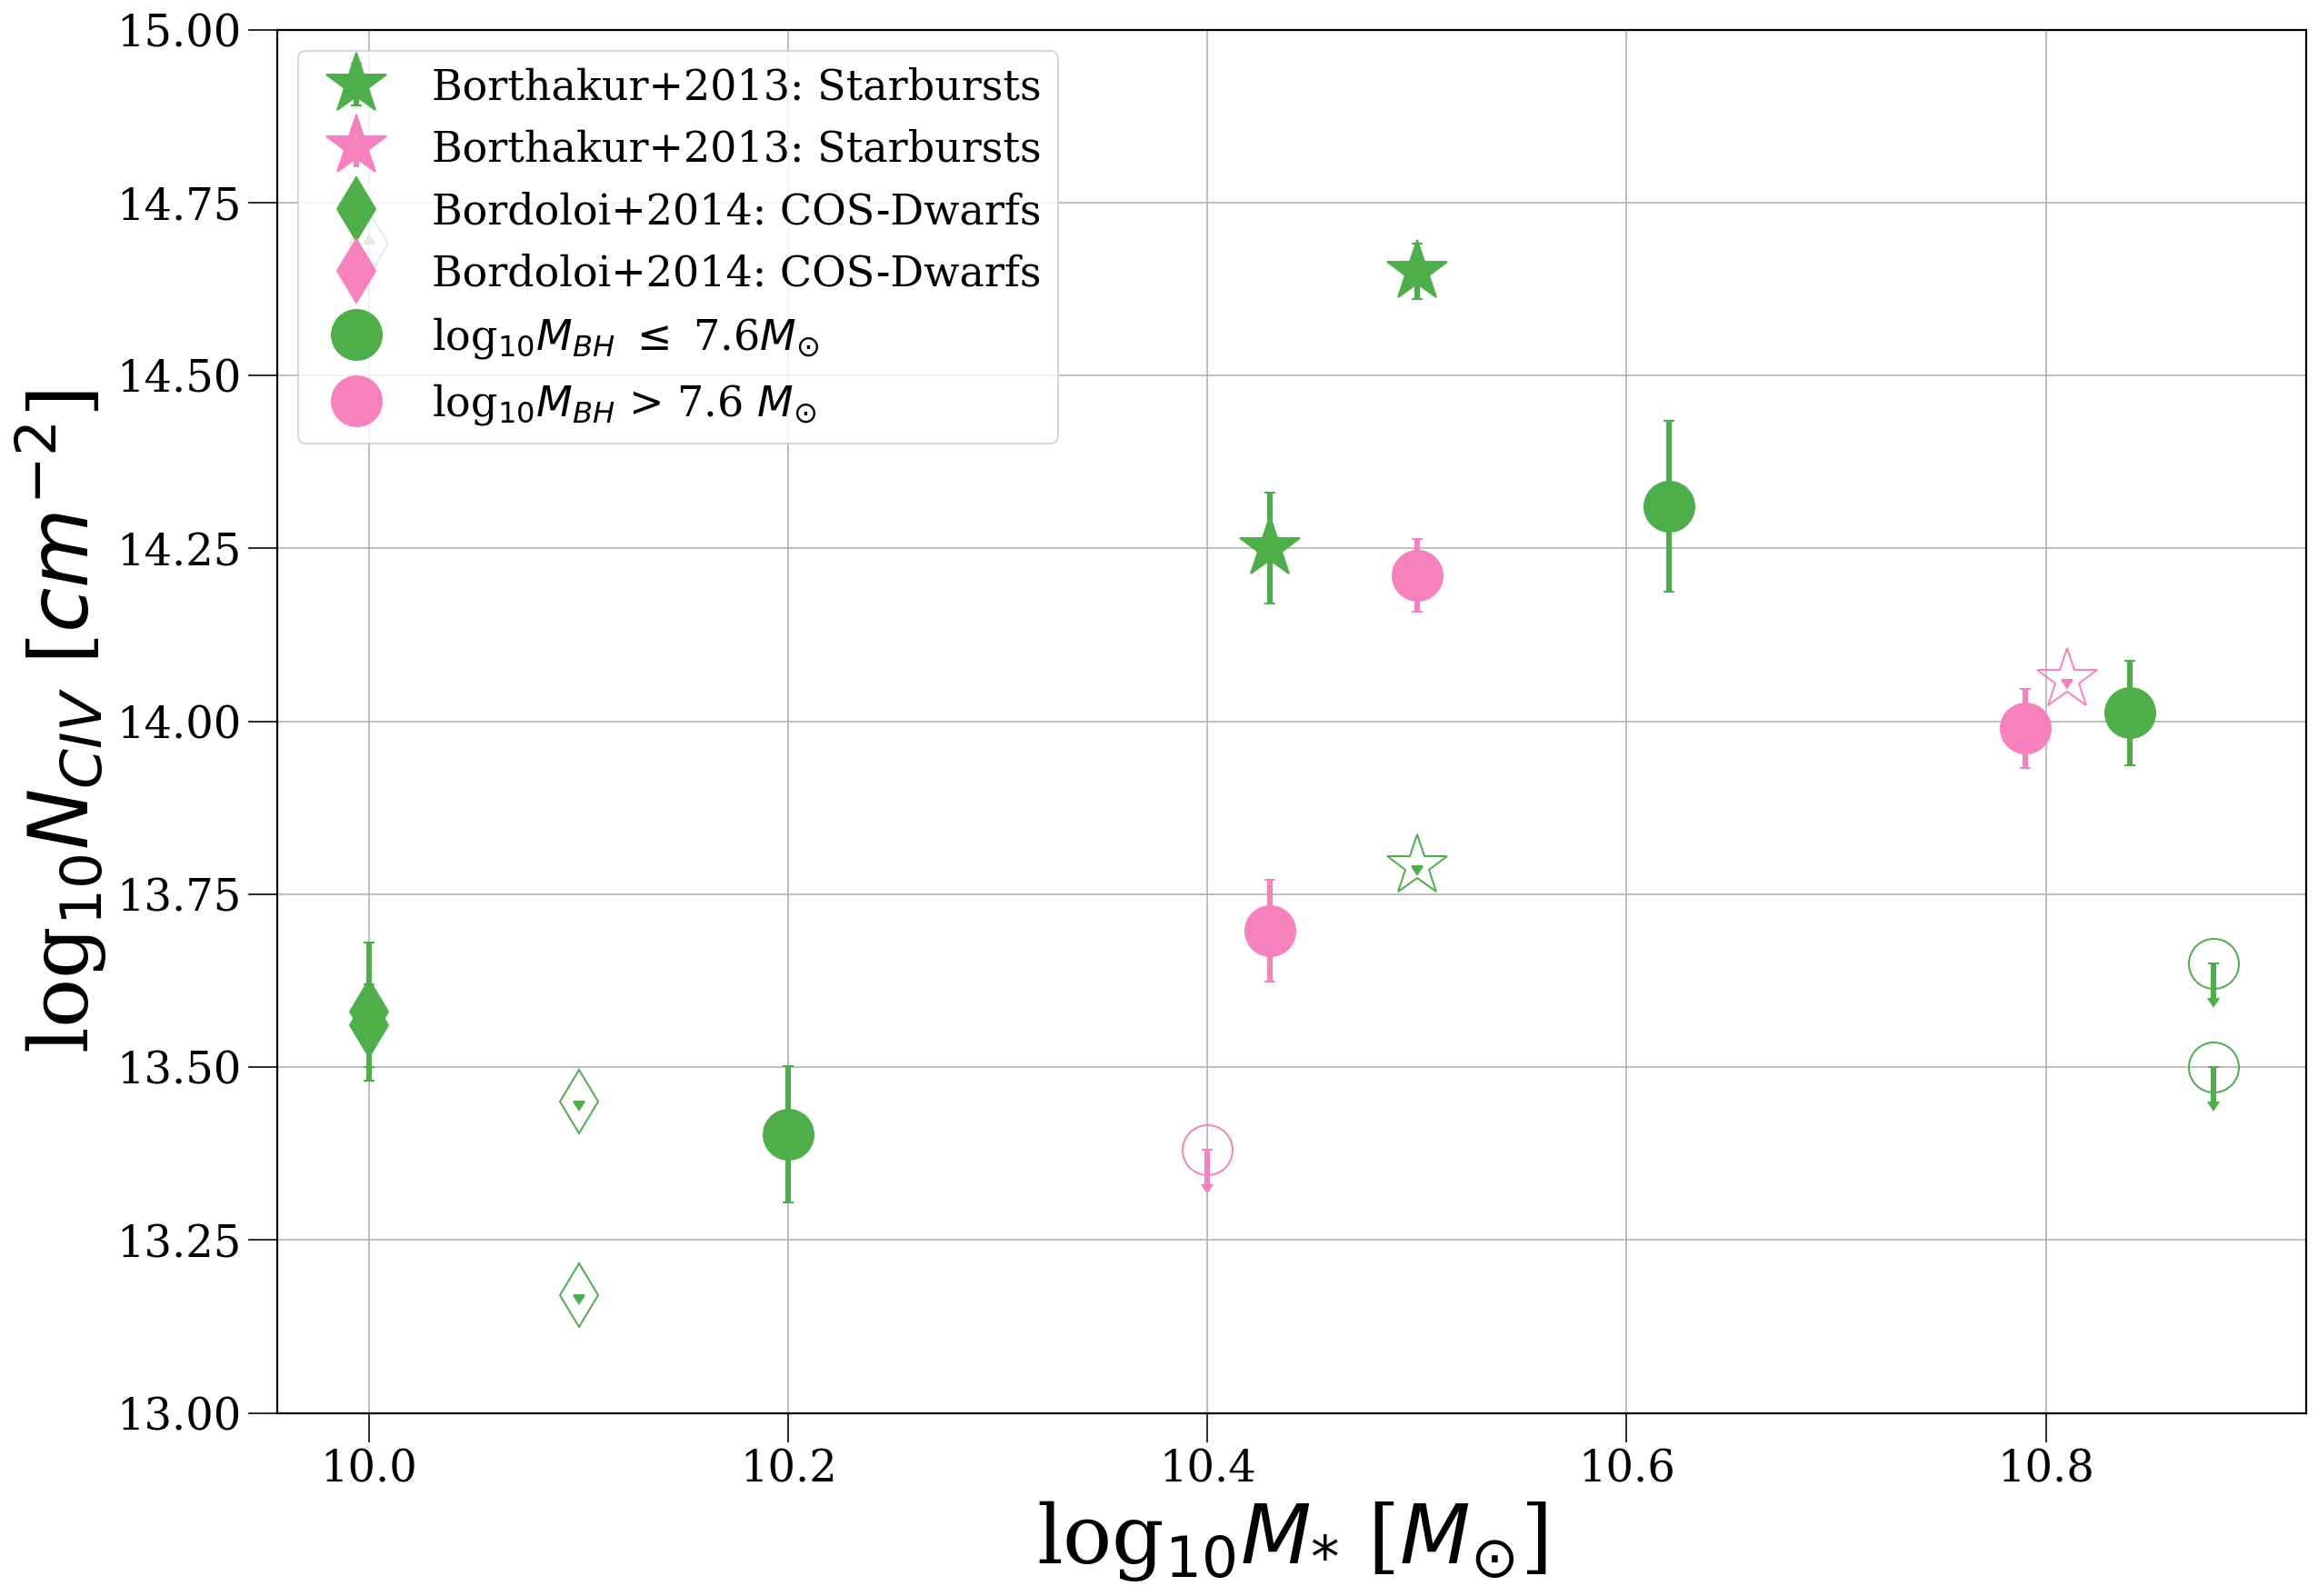

In [34]:
#Plotting NCIV vs M*    
fig, ax = plt.subplots()

########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['mstar[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['mstar[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['logM*'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['logM*'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['logM*'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6$M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["M*"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["M*"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=2, fontsize=23)
ax.set_xlabel(r"log$_{10}M_{*}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
plt.grid(True)
plt.show()

## Comparing COS-Holes Data to Literature and Simulations 

<>:12: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/2323188671.py:12: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)


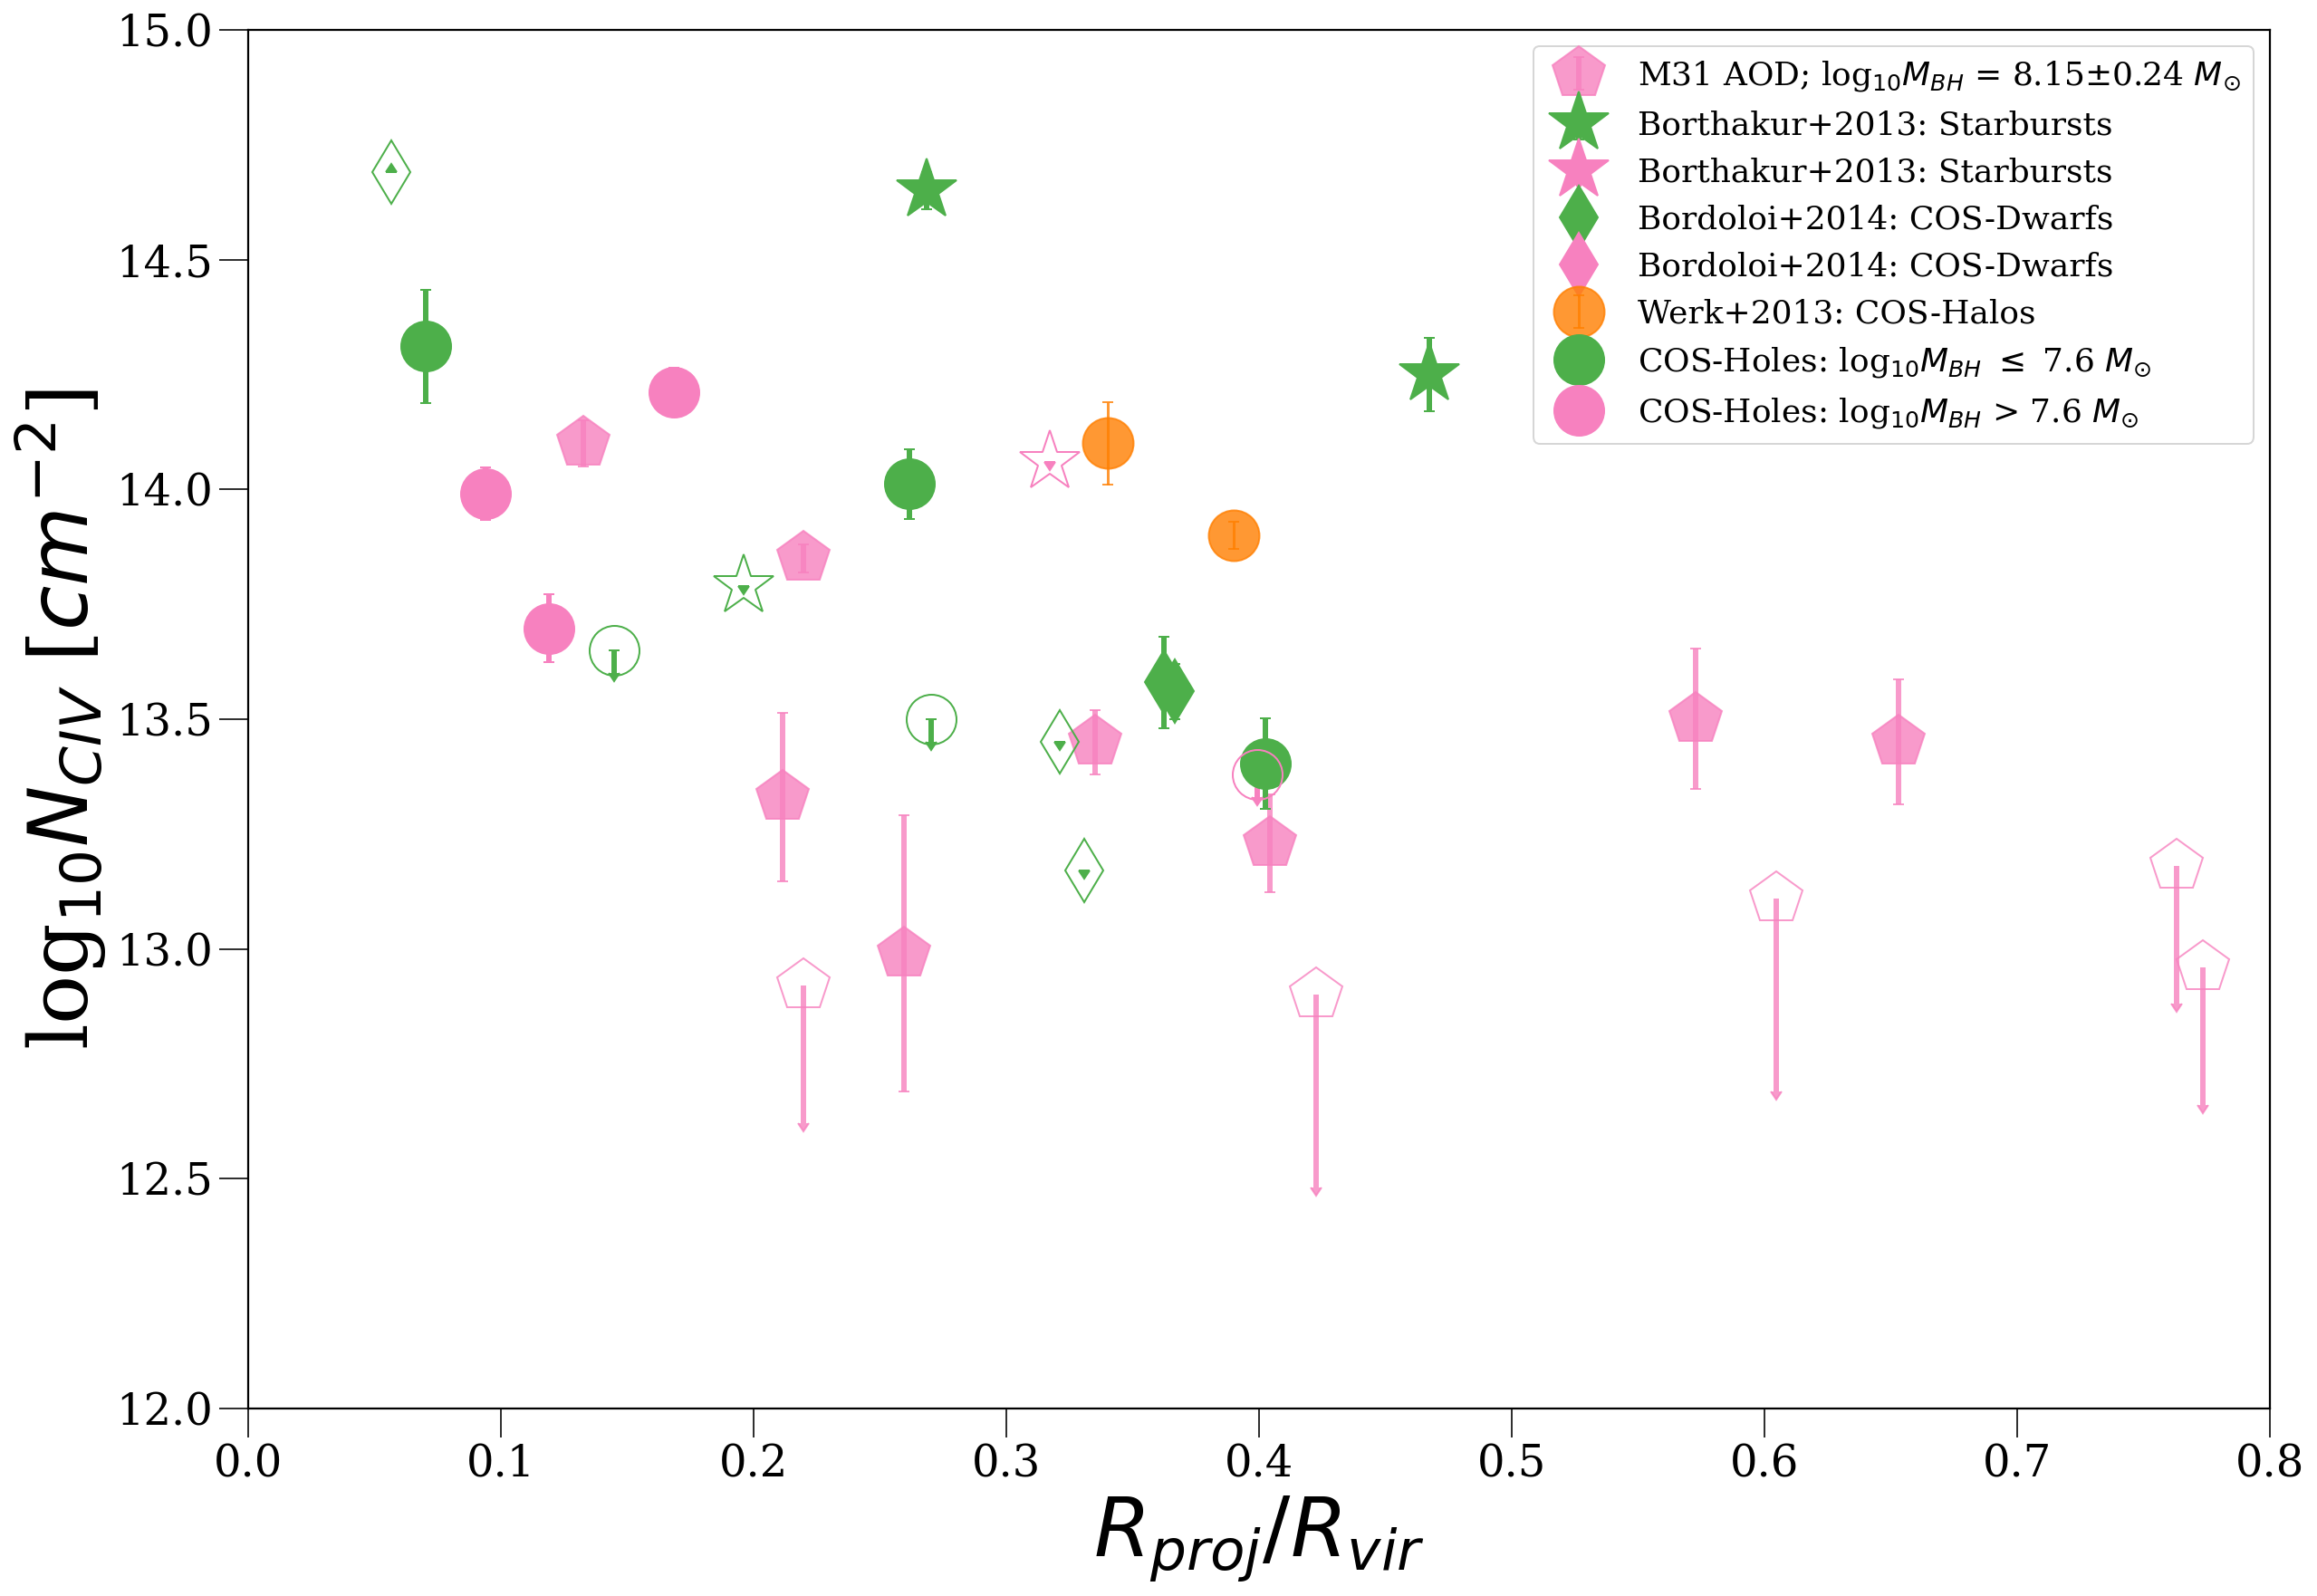

In [35]:
#Plotting NCIV vs Rproj/Rvir 

fig, ax = plt.subplots()

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[3], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)


########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['rhokpc[i]/rvir[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['rhokpc[i]/rvir[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['R/Rvir'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['R/Rvir'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['R/Rvir'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)


########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

<>:12: DeprecationWarning: invalid escape sequence \o
<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \o
<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \o
<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/871203392.py:12: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/871203392.py:15: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/871203392.py:24: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, mar

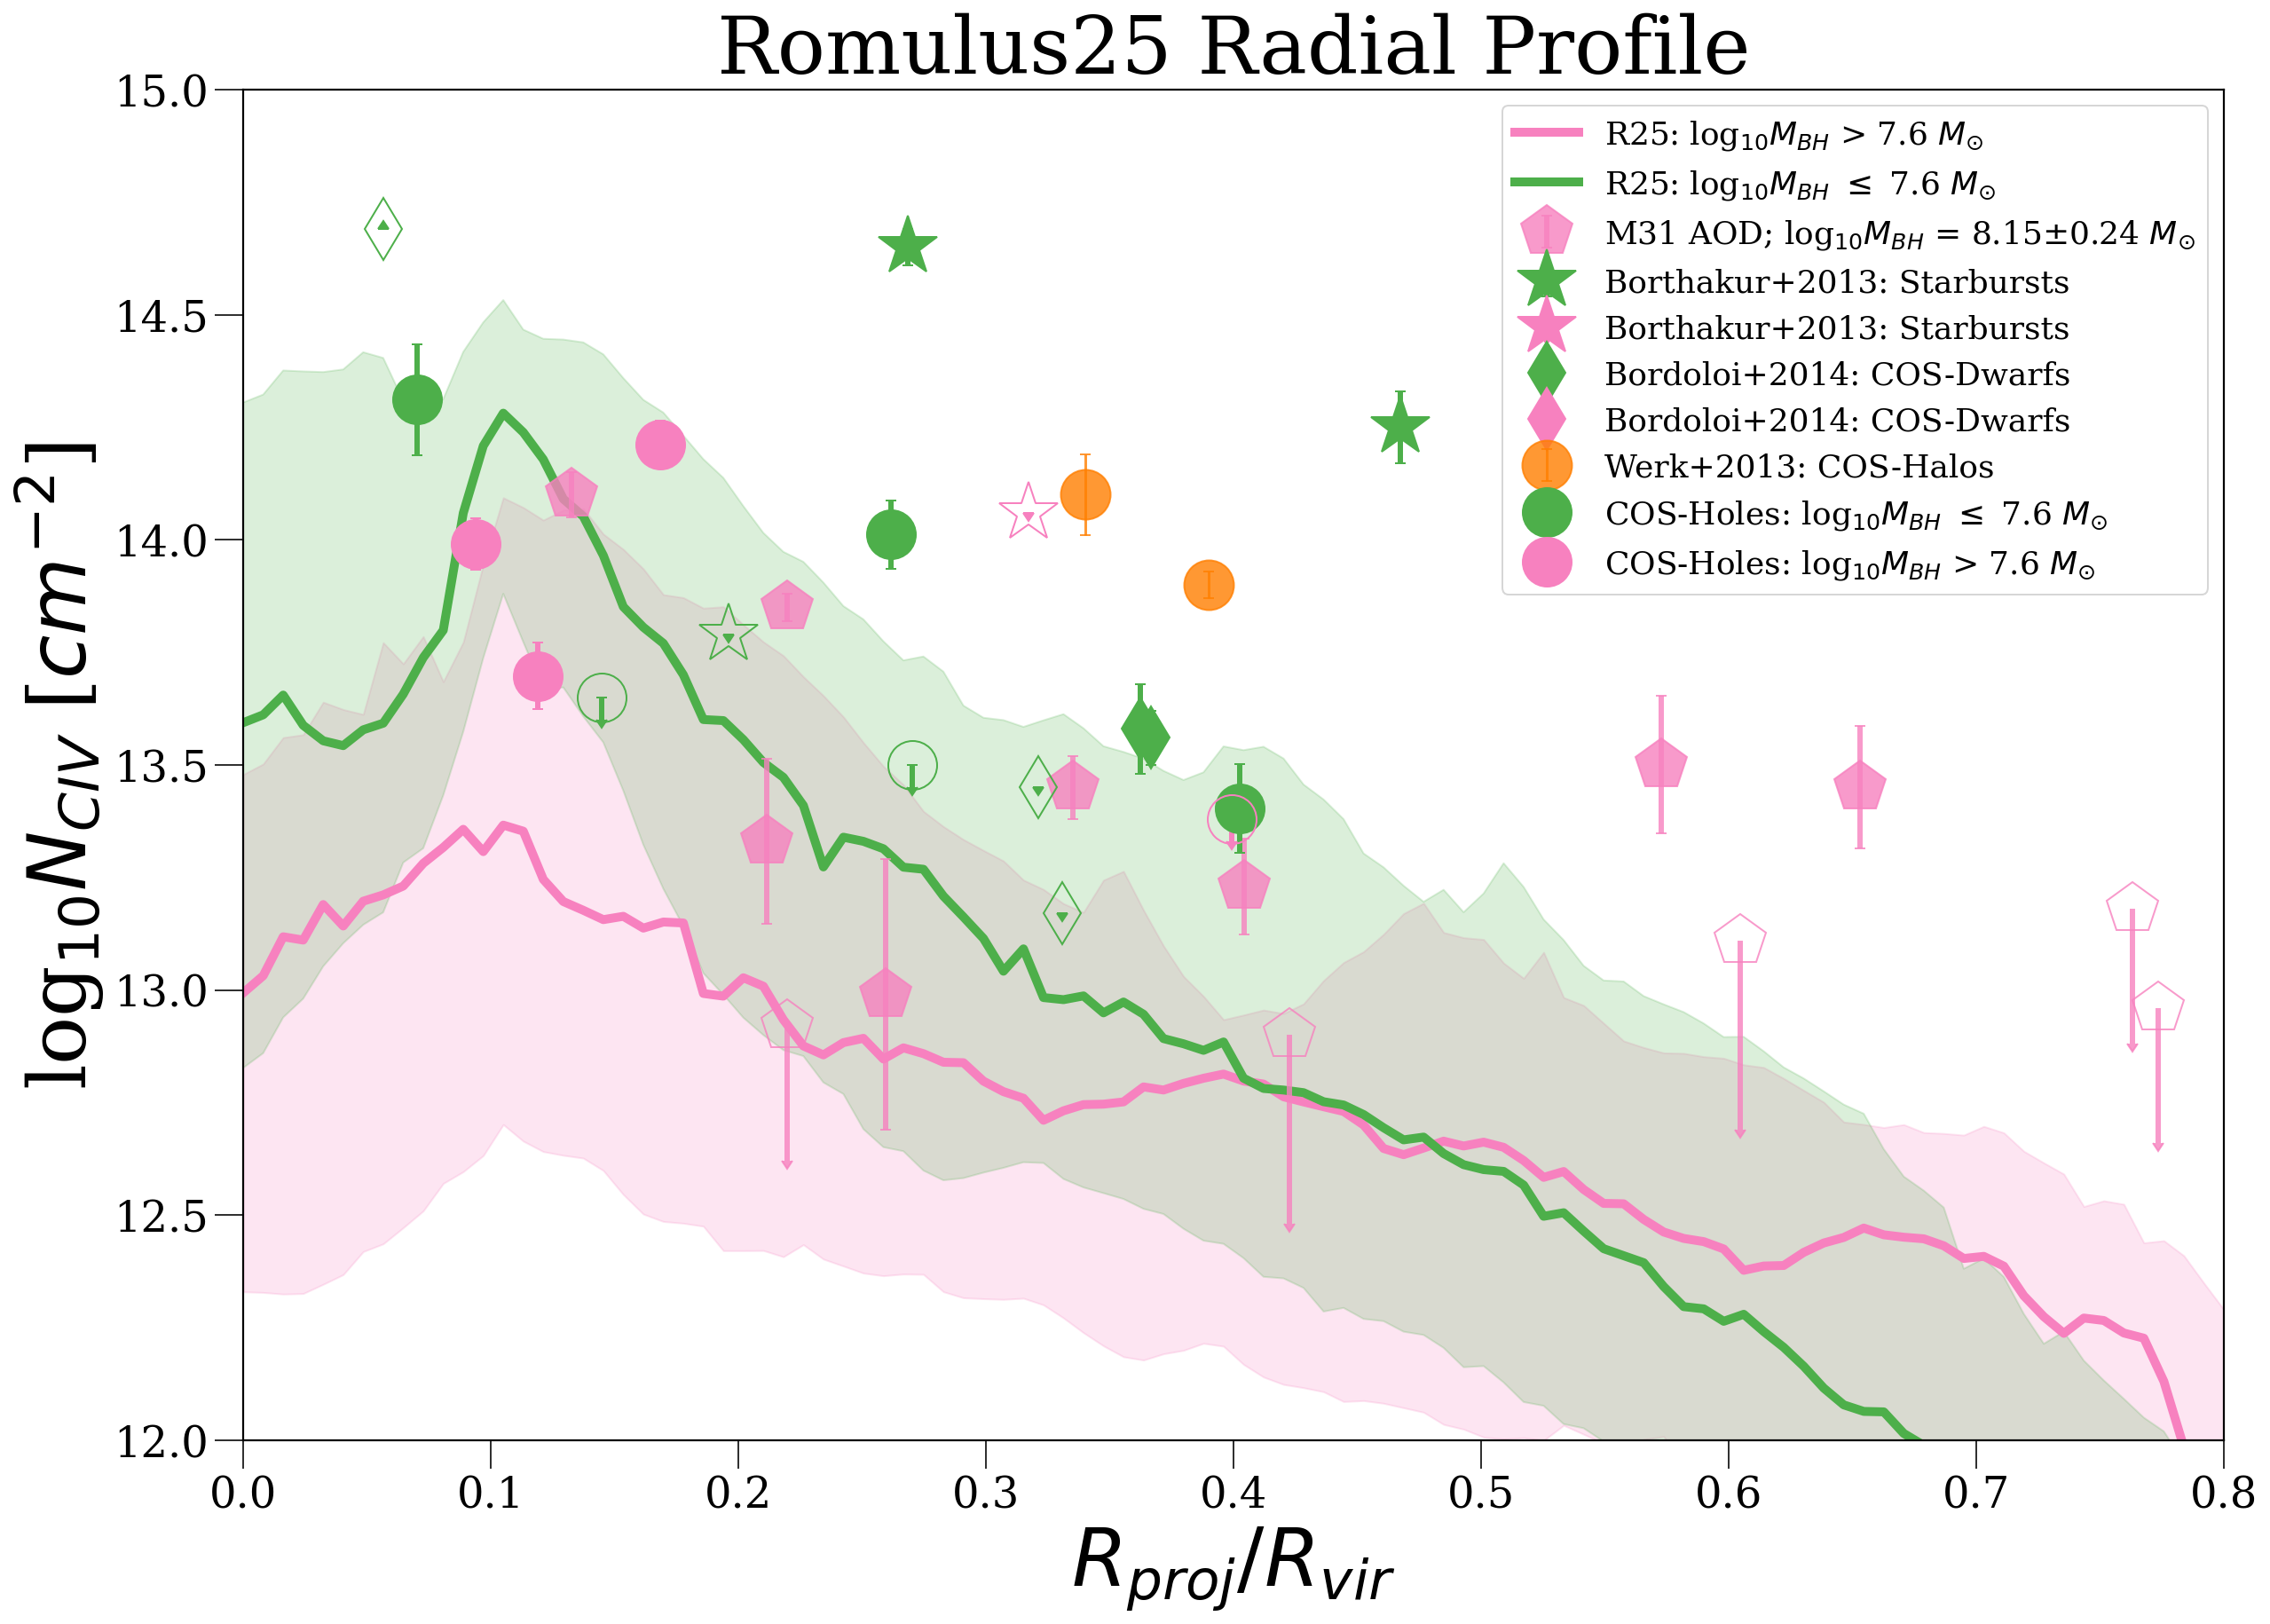

In [48]:
#Plotting NCIV vs Rproj/Rvir for R25

fig, ax = plt.subplots()


########################################################

#R25

plt.fill_between(r25_rr['Rproj/Rvir'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(r25_rr['Rproj/Rvir'], hmbh_civ['logNciv'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(r25_rr['Rproj/Rvir'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(r25_rr['Rproj/Rvir'], lmbh_civ['logNciv'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[3], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)


########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['rhokpc[i]/rvir[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['rhokpc[i]/rvir[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['R/Rvir'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['R/Rvir'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['R/Rvir'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)


########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_title('Romulus25 Radial Profile', fontsize=45)
ax.set_ylim(12, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/2583081907.py:11: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.4-9.8; n=710')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/2583081907.py:13: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label

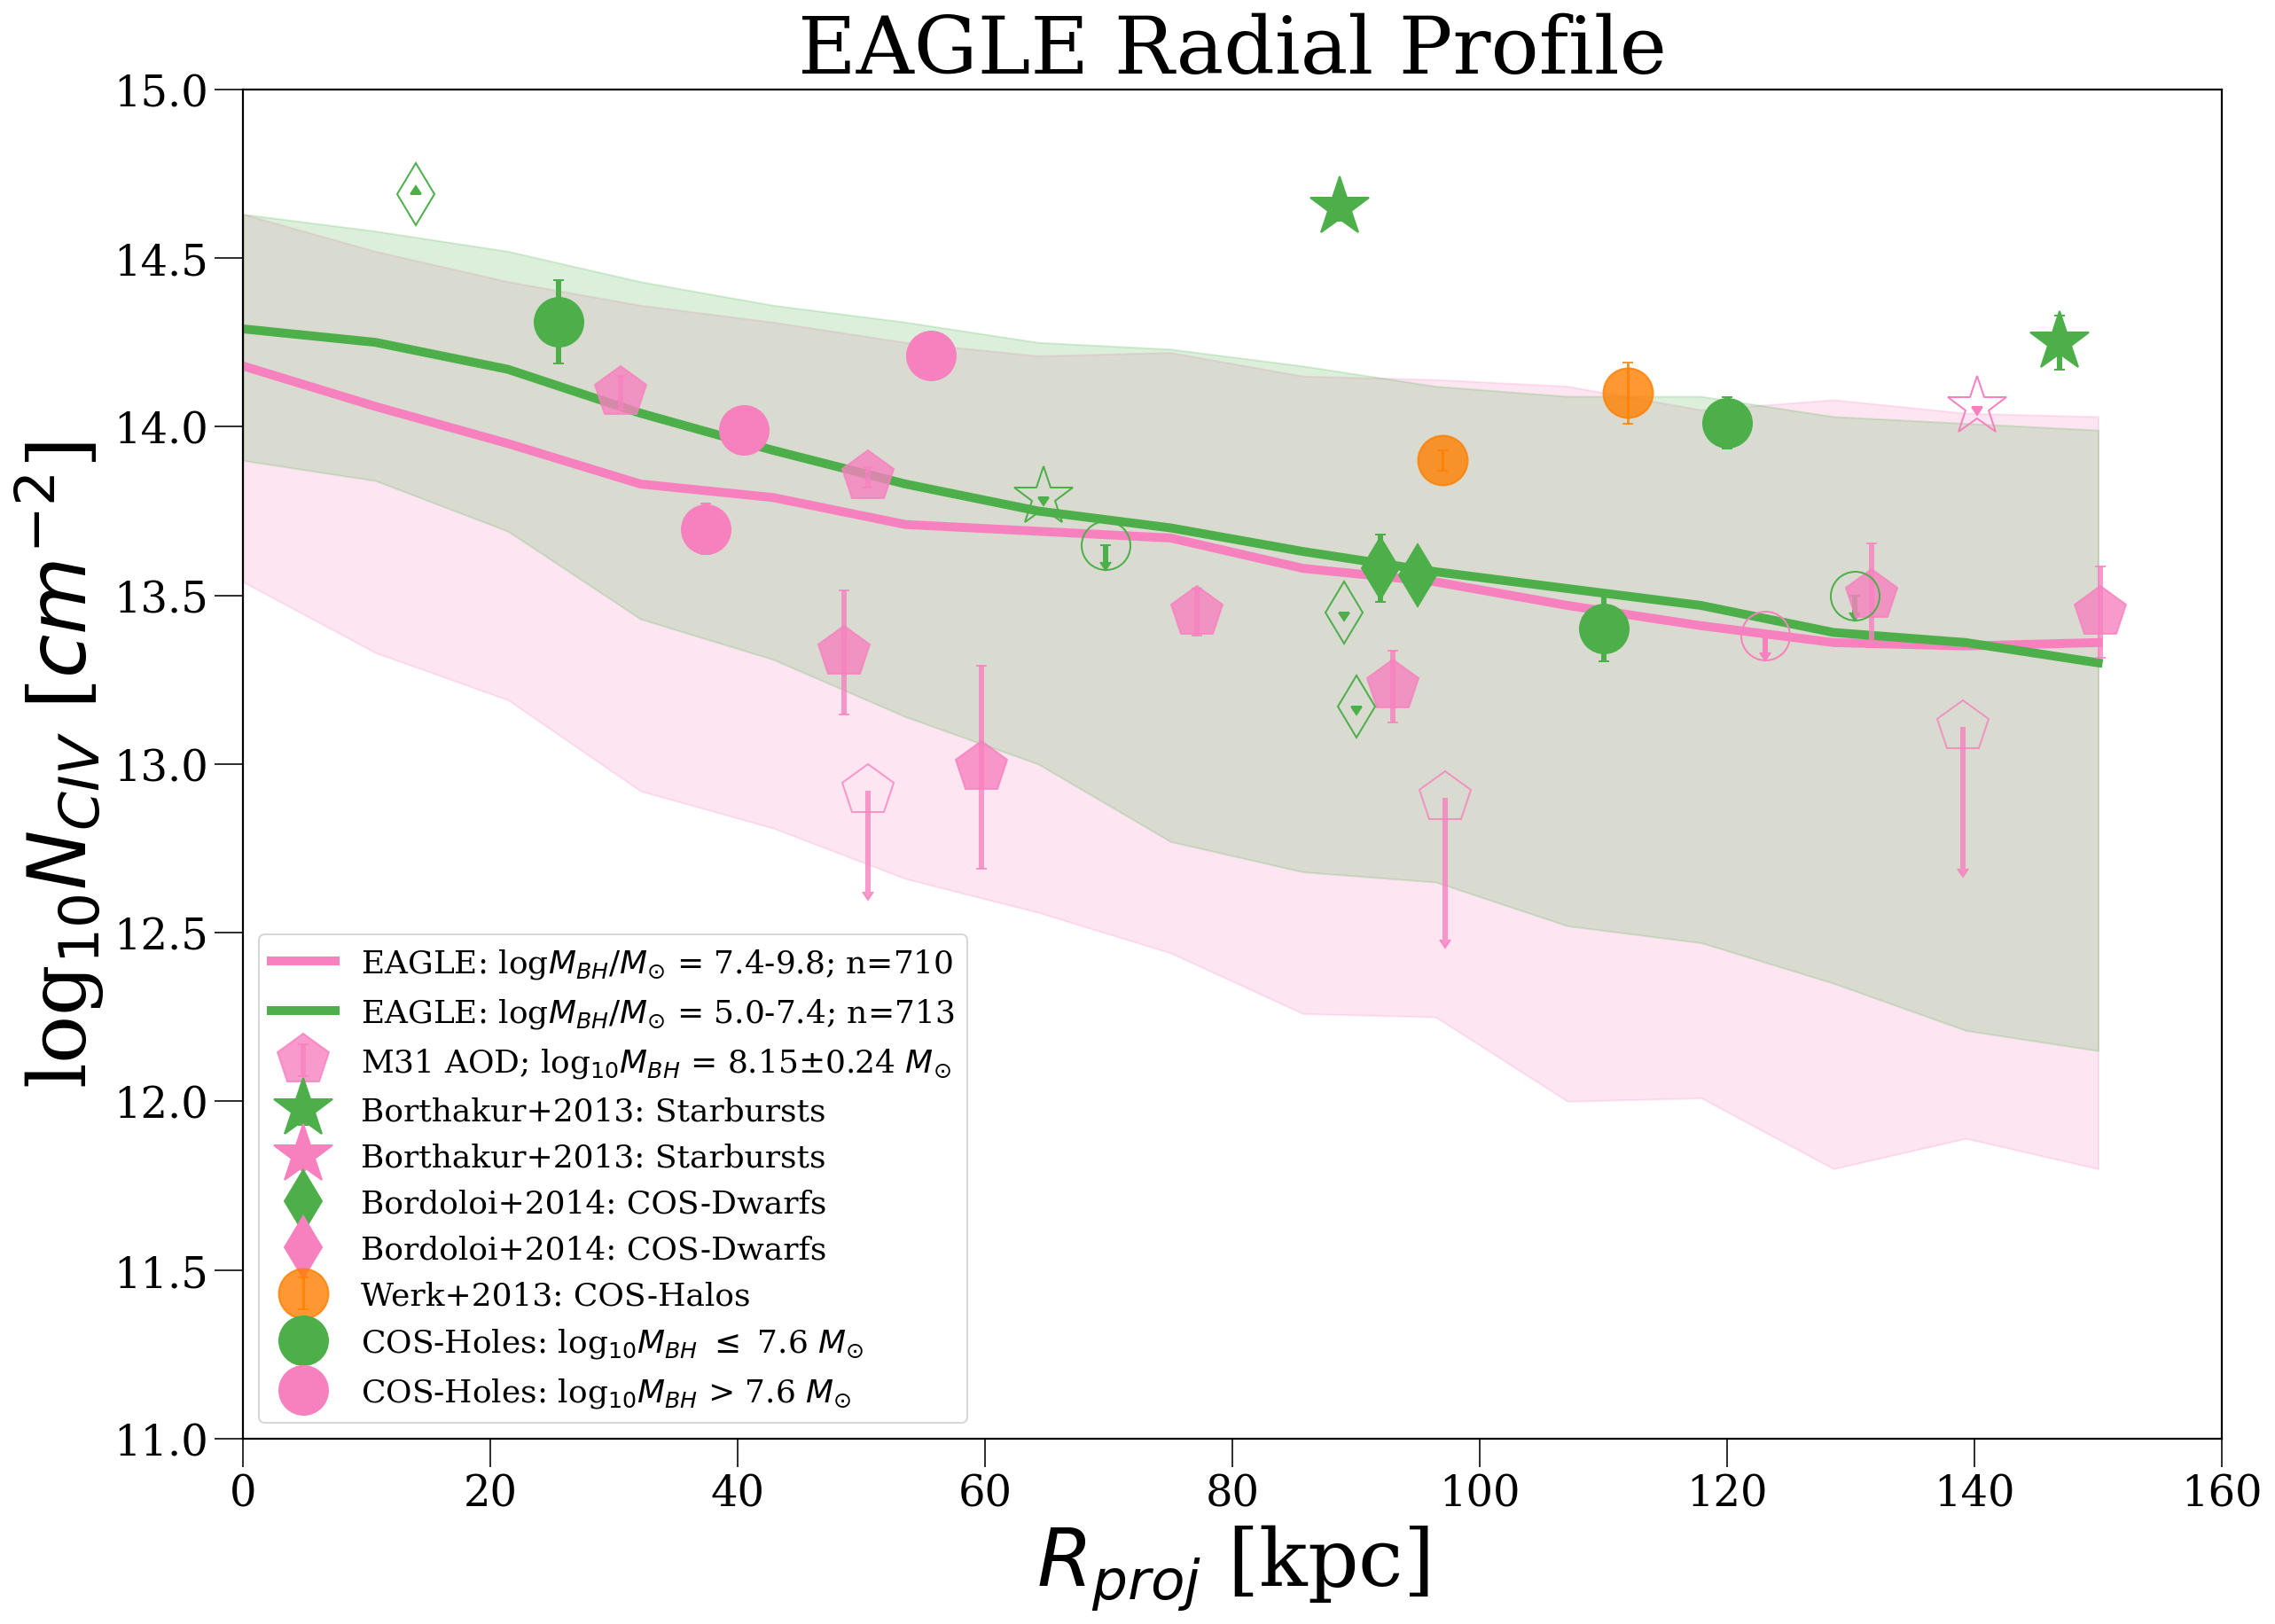

In [49]:
#Plotting NCIV vs Rproj/Rvir for R25

fig, ax = plt.subplots()


########################################################

#EAGLE Simulational Data

plt.fill_between(df_r_new_high['#R(kpc)'], df_r_new_high['16percentile'], df_r_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.4-9.8; n=710')
plt.fill_between(df_r_new_low['#R(kpc)'], df_r_new_low['16percentile'], df_r_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 5.0-7.4; n=713')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_R, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_R, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[3], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)


########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['rhokpc[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['rhokpc[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['R[kpc]'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['R[kpc]'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['R[kpc]'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)


########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_title('EAGLE Radial Profile', fontsize=45)
ax.set_ylim(11, 15)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/3809451152.py:11: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.2-10.4; n=1054')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/3809451152.py:13: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color = CB_color_cycle[2], l

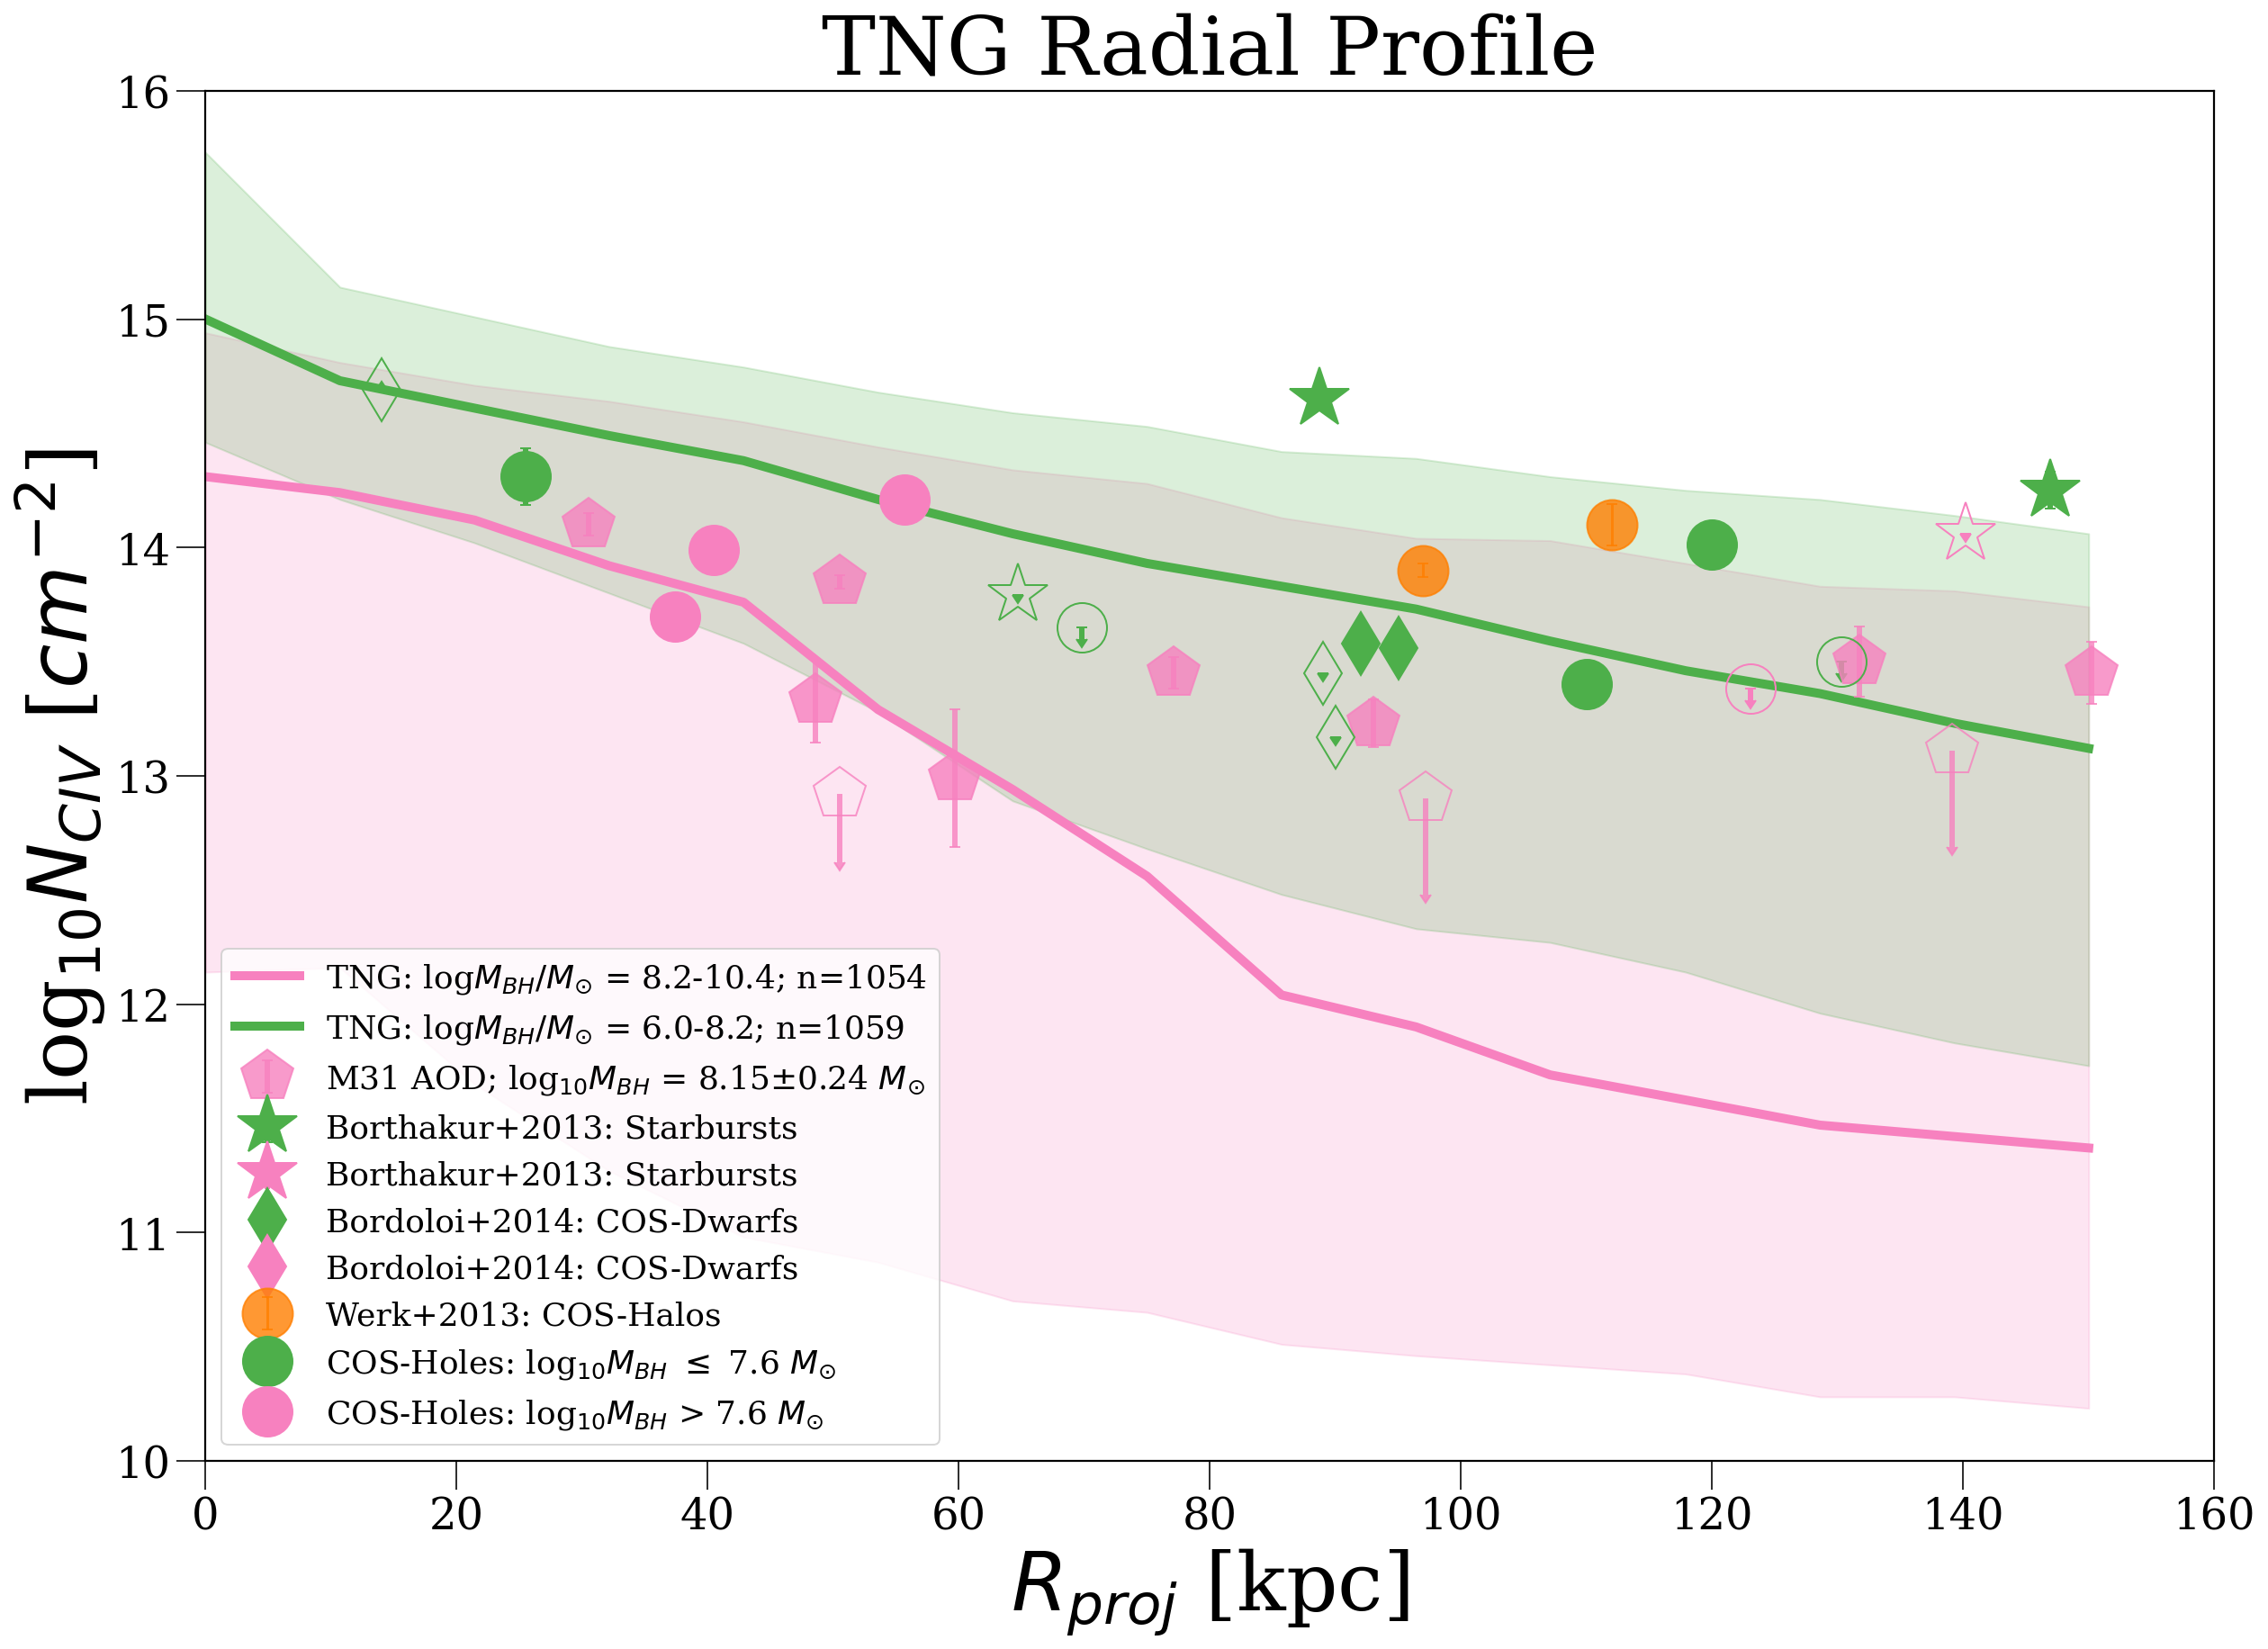

In [50]:
#Plotting NCIV vs Rproj/Rvir for R25

fig, ax = plt.subplots()


########################################################

#TNG Simulational Data

plt.fill_between(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['16percentile'], df_r_new_hightng['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_r_new_hightng['#R(kpc)'], df_r_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.2-10.4; n=1054')
plt.fill_between(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['16percentile'], df_r_new_lowtng['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color = CB_color_cycle[2], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 6.0-8.2; n=1059')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_R, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_R, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[3], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)


########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['rhokpc[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['rhokpc[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['R[kpc]'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['R[kpc]'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['R[kpc]'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)


########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_title('TNG Radial Profile', fontsize=45)
ax.set_ylim(10, 16)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

## Making a bestfit line through the "larger" data sample

In [ ]:
#Why is this not working????? 
    #NEW IDEA: 
    #Make all the dfs have the same length and have the same name as cos_sup and then concatenate them all 

In [138]:
cos_sup = pd.concat([sum_ch, up_ch])
cos_sup = cos_sup.drop(['galaxy', 'zgal', 'Mhalo', 'SFR', 'vrel', 'line', 'wav', 'zsys', 'b', 'sigb', 'vel', 'sigvel', 'comp', 'Vhelio [km/s]'], axis=1)
cos_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770,0.065,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255,0.125,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830,0.123,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400,0.071,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920,0.048,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140,0.090,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577,0.030,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577,0.030,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940,0.145,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0


In [78]:
borth_sup = borthakur_new.drop(['alog10(mhalo[i])'], axis=1)
borth_sup = borth_sup.rename(columns={"galname[i]": "QSO", "MBH": "MBH", "MBH_err": "sigMBH","mstar[i]": "M*",
                         "rhokpc[i]": "Rproj", "rvir[i]": "Rvir", "rhokpc[i]/rvir[i]": "Rproj/Rvir",
                         "logNCIV[i]": "N", "err": "sigN", "det": "uplim",})
borth_sup = borth_sup.iloc[:,[0,8,9,1,3,2,4,5,6,7]]
borth_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J154527.12+484642.2,6.105340,2.695157,10.50,64.7,330.32571,0.195867,13.79,0.00,0
1,J132150.89+033034.1,7.629189,0.935723,10.81,140.2,441.86569,0.317291,14.06,0.00,0
2,J102846.43+391842.9,7.160030,2.898395,10.50,88.7,330.32571,0.268523,14.65,0.04,1
3,J140502.20+470525.9,7.398128,3.552522,10.43,146.9,314.35077,0.467312,14.25,0.08,1


In [87]:
bord_sup = bordoloi_new.rename(columns={"QSO": "QSO", "logNCIV": "N", "err": "sigN","det": "uplim",
                         "logM*": "M*", "R[kpc]": "Rproj", "Rvir[kpc]": "Rvir",
                         "R/Rvir": "Rproj/Rvir", "MBH": "MBH", "MBH_err": "sigMBH",})
bord_sup = bord_sup.iloc[:,[0,8,9,4,5,6,7,1,2,3]]
bord_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1211+3657,5.446784,2.086028,10.1,90,272,0.330882,13.17,0.00,0
1,J1121+0325,4.699188,1.408071,10.1,89,277,0.321300,13.45,0.00,0
2,J09525+4535,4.829331,0.822240,10.0,95,259,0.366795,13.56,0.06,1
3,PG1202+281,4.223933,2.662287,10.0,92,254,0.362205,13.58,0.10,1
4,J0959+0503,6.127163,2.736984,10.0,14,247,0.056680,14.69,0.00,2


In [133]:
#making arrays of AMIGA MBH and error so that I can add to df 

#dets 
MBH_amiga = np.full(11, 8.15)
sigMBH_amiga = np.full(11, 0.24)
mstar_amiga = np.full(11, 10.3)
rvir_amiga = np.full(11,230)
uplim = np.full(11,1)

#ups
MBH_amiga_up = np.full(12, 8.15)
sigMBH_amiga_up = np.full(12, 0.24)
mstar_amiga_up = np.full(12, 10.3)
rvir_amiga_up = np.full(12,230)
uplim_up = np.full(12,0)

In [132]:
amiga_det = amiga_2_det_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_det['amiga_det_RRvir'] = amiga_det_RRvir.tolist()
amiga_det['MBH_amiga'] = MBH_amiga.tolist()
amiga_det['sigMBH_amiga'] = sigMBH_amiga.tolist()
amiga_det['mstar_amiga'] = mstar_amiga.tolist()
amiga_det['rvir_amiga'] = rvir_amiga.tolist()
amiga_det['uplim'] = uplim.tolist()

amiga_det = amiga_det.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN', 
                                      'amiga_det_RRvir': 'Rproj/Rvir', 'MBH_amiga': 'MBH', 'sigMBH_amiga': 'sigMBH', 'mstar_amiga': 'M*', 
                                     'rvir_amiga': 'Rvir','uplim': 'uplim'})

amiga_det = amiga_det.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

amiga_det

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
3,HS0033+4300,8.15,0.24,10.3,30.5,230,0.132609,14.10,0.050000,1
4,HS0058+4213,8.15,0.24,10.3,48.6,230,0.211304,13.33,0.183848,1
6,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,13.85,0.030000,1
7,Zw535.012,8.15,0.24,10.3,59.7,230,0.259565,12.99,0.300167,1
9,RX_J0050.8+3536,8.15,0.24,10.3,77.1,230,0.335217,13.45,0.070000,1
10,IRAS_F00040+4325,8.15,0.24,10.3,93.0,230,0.404348,13.23,0.106301,1
12,MRK352,8.15,0.24,10.3,131.7,230,0.572609,13.50,0.152971,1
15,KAZ238,8.15,0.24,10.3,150.2,230,0.653043,13.45,0.136015,1
17,PG0052+251,8.15,0.24,10.3,209.8,230,0.912174,13.41,0.064031,1
19,RXS_J0155.6+3115,8.15,0.24,10.3,231.6,230,1.006957,13.92,0.050000,1


In [134]:
amiga_up = amiga_2_up_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_up['amiga_up_RRvir'] = amiga_up_RRvir.tolist()
amiga_up['MBH_amiga_up'] = MBH_amiga_up.tolist()
amiga_up['sigMBH_amiga_up'] = sigMBH_amiga_up.tolist()
amiga_up['mstar_amiga_up'] = mstar_amiga_up.tolist()
amiga_up['rvir_amiga_up'] = rvir_amiga_up.tolist()
amiga_up['uplim_up'] = uplim_up.tolist()

amiga_up = amiga_up.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN',
                                      'amiga_up_RRvir': 'Rproj/Rvir', 'MBH_amiga_up': 'MBH', 'sigMBH_amiga_up': 'sigMBH', 
                                    'mstar_amiga_up': 'M*', 'rvir_amiga_up': 'Rvir', 'uplim_up': 'uplim'})

amiga_up = amiga_up.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

amiga_up

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
1,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,12.92,0.300000,0
5,RXS_J0118.8+3836,8.15,0.24,10.3,97.2,230,0.422609,12.90,0.420000,0
7,RX_J0028.1+3103,8.15,0.24,10.3,139.1,230,0.604783,13.11,0.420000,0
10,FBS0150+396,8.15,0.24,10.3,175.5,230,0.763043,13.18,0.300000,0
11,3C48.0,8.15,0.24,10.3,177.9,230,0.773478,12.96,0.300000,0
14,RBS2055,8.15,0.24,10.3,238.6,230,1.037391,13.10,0.300000,0
15,3C66A,8.15,0.24,10.3,242.2,230,1.053043,12.79,0.300000,0
19,MRK1148,8.15,0.24,10.3,311.6,230,1.354783,12.66,0.300000,0
20,MRK1179,8.15,0.24,10.3,341.0,230,1.482609,13.00,0.300000,0
21,UGC12163,8.15,0.24,10.3,349.2,230,1.518261,13.01,0.519615,0


In [140]:
coslit = pd.concat([cos_sup, borth_sup, bord_sup, amiga_det, amiga_up])
coslit

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770000,0.065000,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255000,0.125000,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830000,0.123000,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400000,0.071000,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920000,0.048000,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140000,0.090000,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577000,0.030000,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577000,0.030000,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940000,0.145000,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0
0,J154527.12+484642.2,6.105340,2.695157,10.50,64.700000,330.32571,0.195867,13.790000,0.000000,0


In [141]:
##### CIV #####

XX =  np.copy(coslit['Rproj/Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(coslit["N"]) #getting the column density of CIV from main data table 
YY_err = np.copy(coslit["sigN"]) #column density error of CIV 
UL = np.copy(coslit['uplim']) #1 = det and 0= uplim 
has_UL = UL < 1 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}

In [142]:
##### CIV #####

upper_lim_Crr = yCrr_err < 0 #a mask to find the upper limits for later stuff I think 

delta_Crr = np.invert(upper_lim_Crr) #array of True and False 
xsig_Crr = np.zeros_like(xCrr) #array of 0s like xC => like XX => the impact parameters bc they dont have error oh i see
ysig_Crr = yCrr_err[:] #error of the column densities 

lmcens_Crr = linmix.LinMix(xCrr, yCrr, xsig_Crr, ysig_Crr, delta=delta_Crr, K=2)
lmcens_Crr.run_mcmc(silent=True)

yints_Crr = lmcens_Crr.chain['alpha'] #same shape as the Nboot (looks like 12-14 values)
slopes_Crr = lmcens_Crr.chain['beta'] #same shape as the Nboot (looks like very very small values)

mean_yint_Crr = yints_Crr.mean() #mean alpha value (~14)
mean_slope_Crr = slopes_Crr.mean() #mean beta value (~ -0.010)

xxrr = np.linspace(0,1,1000) #This is how long the line is gonna be
all_lines_Crr = np.array([m*xxrr + b for (m,b) in zip(slopes_Crr, yints_Crr)]) #makng the equation

lo_line_Crr, med_line_Crr, hi_line_Crr = np.percentile(all_lines_Crr, (16,50,84), axis = 0) #percentiles for stats knowledge
mean_line_Crr = mean_slope_Crr*xxrr + mean_yint_Crr #mean line equation

<>:15: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_47400/4231798895.py:15: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)


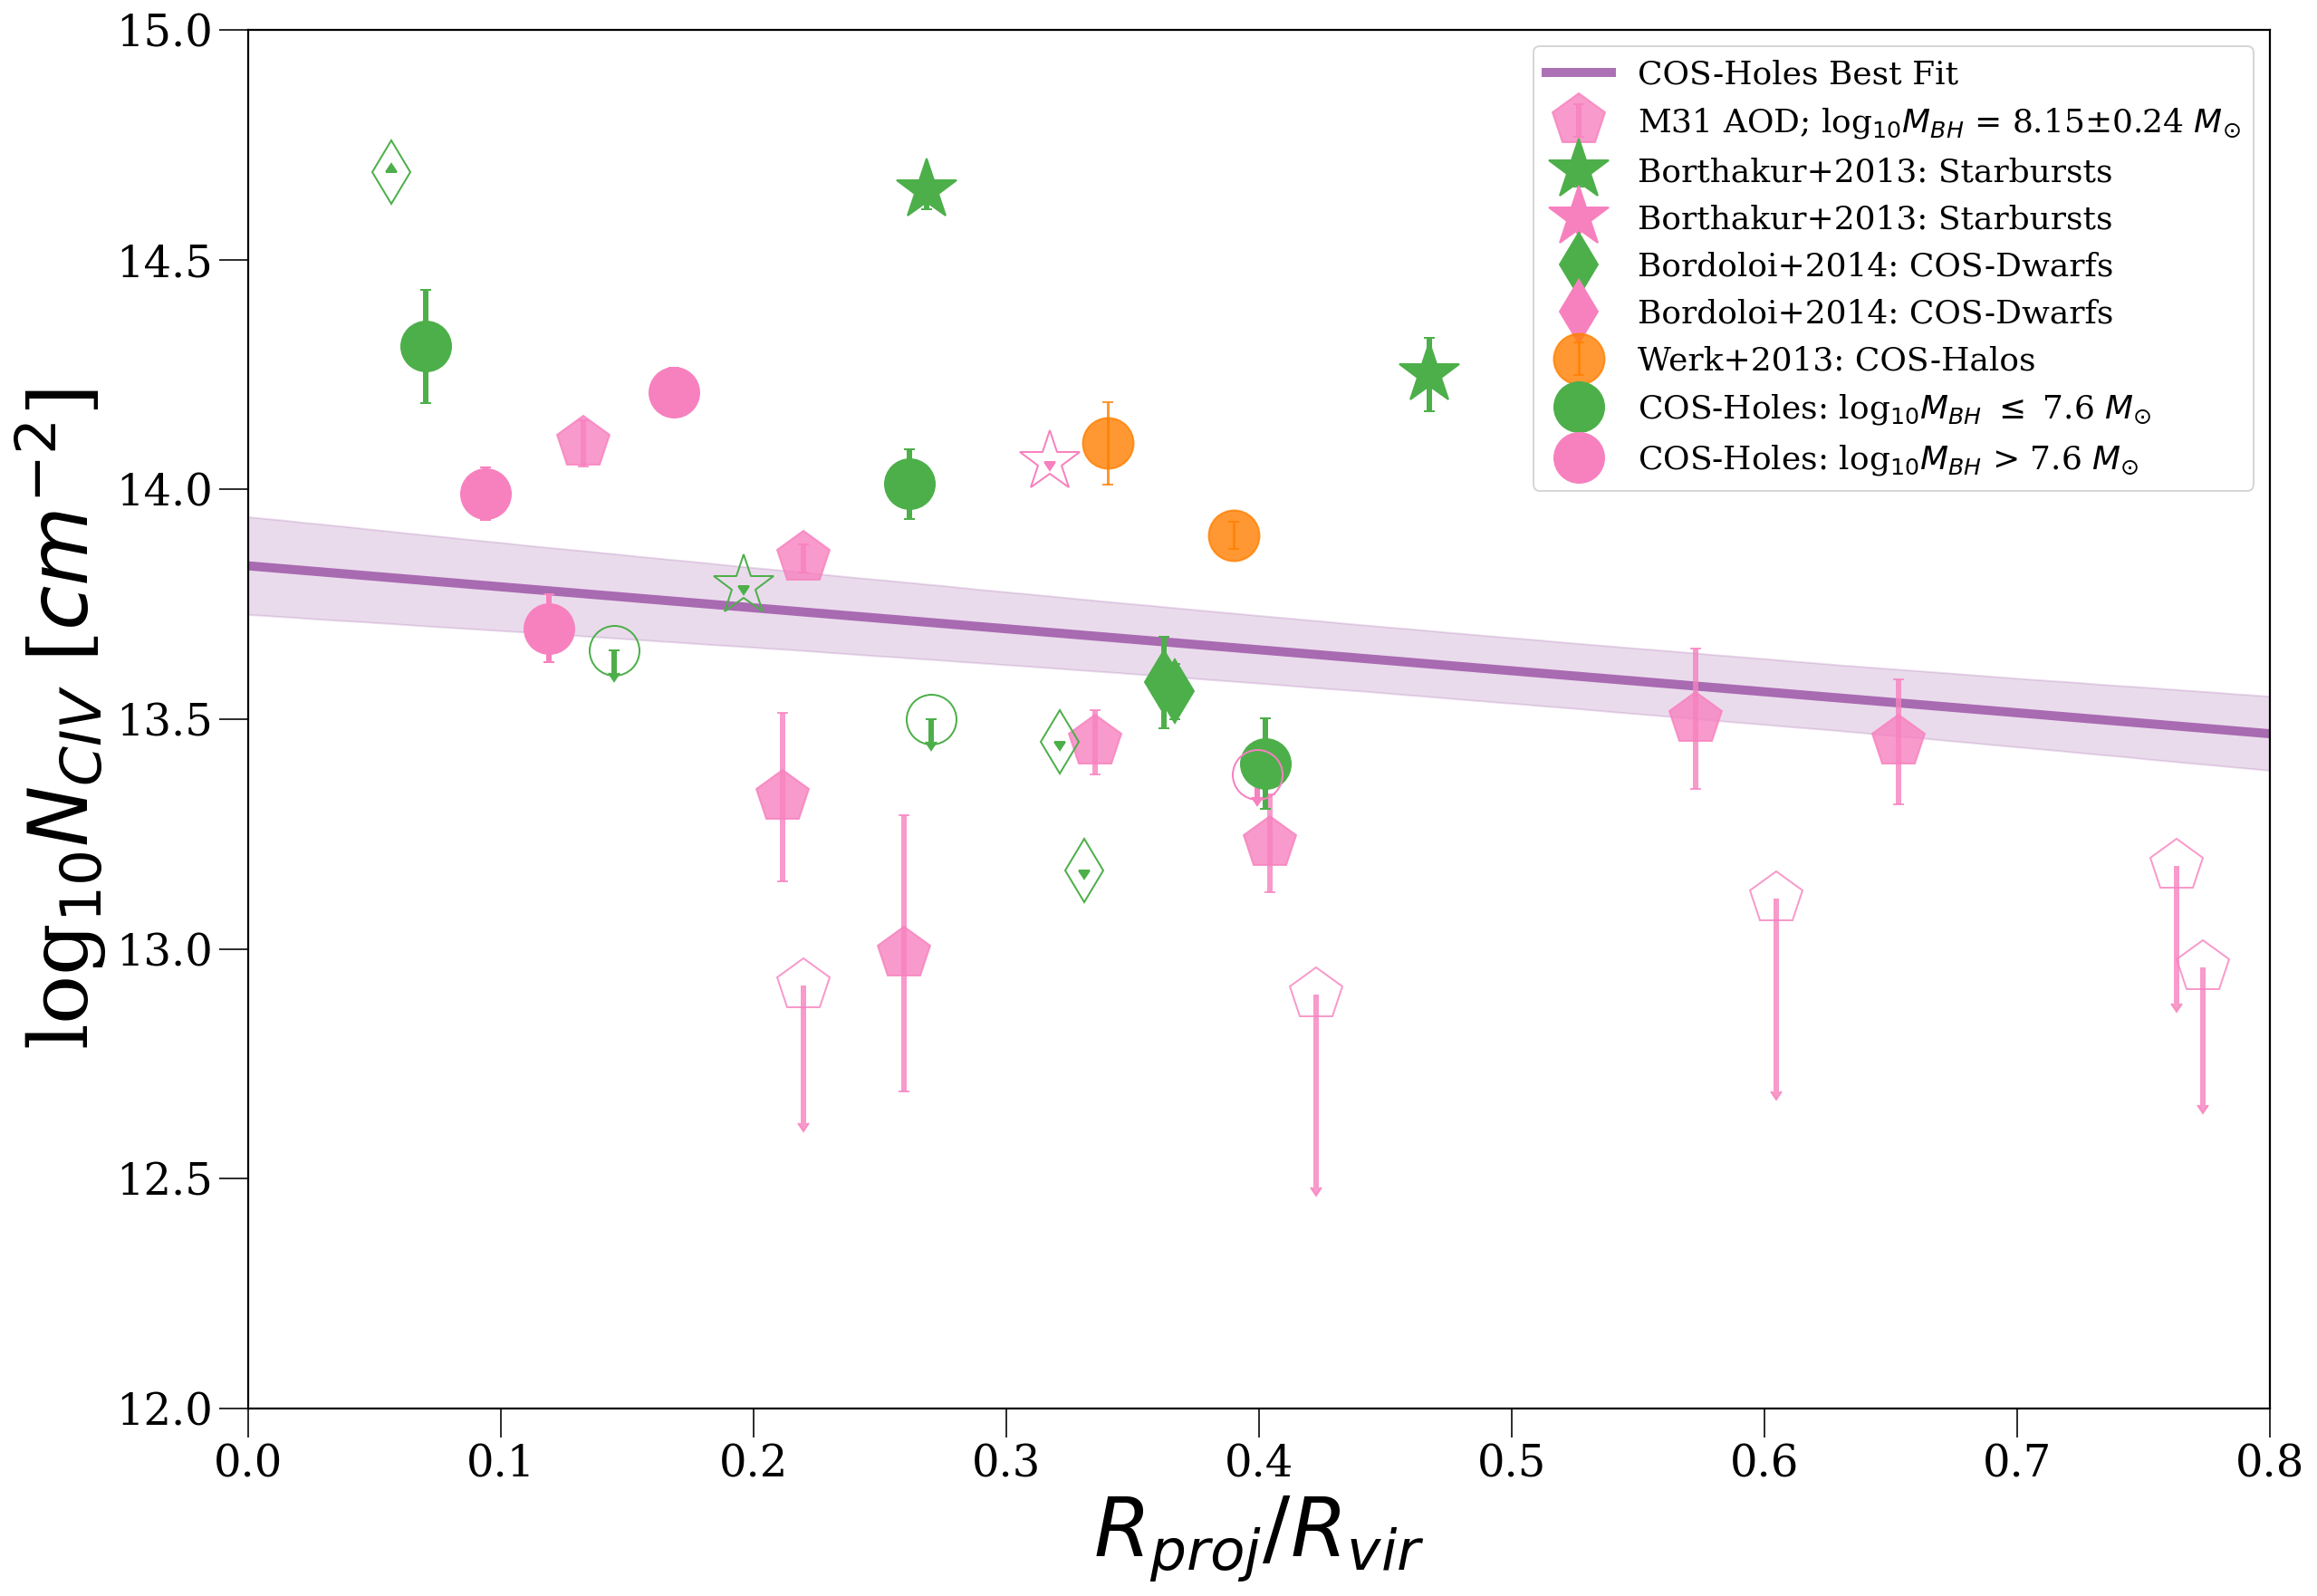

In [143]:
fig, ax = plt.subplots()

plt.plot(xxrr, mean_line_Crr, color = CB_color_cycle[5], alpha = 0.8,lw = 5, ls = "-", label='COS-Holes Best Fit')
plt.fill_between(xxrr, lo_line_Crr, hi_line_Crr, color =CB_color_cycle[5], alpha = 0.2)

#Plotting NCIV vs Rproj/Rvir 

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det['Rproj/Rvir'], amiga_det['N'], yerr=amiga_det['sigN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up['Rproj/Rvir'], amiga_up['N'], yerr=amiga_up['sigN'],uplims=True, c = CB_color_cycle[3], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)


########################################################
########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Borthakur+2013: Starbursts", 
                                r"Borthakur+2013: Starbursts"]):
    
    ax.errorbar(borth_det['rhokpc[i]/rvir[i]'][mask], borth_det['logNCIV[i]'][mask],yerr=borth_det['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['rhokpc[i]/rvir[i]'][mask], borth_uplim['logNCIV[i]'][mask],yerr=borth_uplim['err'][mask], 
                capsize = 3, c = colour, marker="*", markersize=35, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, label in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Bordoloi+2014: COS-Dwarfs", 
                                r"Bordoloi+2014: COS-Dwarfs"]):
    
    ax.errorbar(bord_det['R/Rvir'][mask], bord_det['logNCIV'][mask],yerr=bord_det['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['R/Rvir'][mask], bord_uplim['logNCIV'][mask],yerr=bord_uplim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['R/Rvir'][mask], bord_lolim['logNCIV'][mask],yerr=bord_lolim['err'][mask], 
                capsize = 3, c = colour, marker="d", markersize=25, ls='none', lolims=True, mfc='none', elinewidth=3)

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)


########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()